# Tracking Eigenvalues: The Shift-Invert Power Method

### 1. The Strategy
When studying how a Hamiltonian $H(\lambda)$ behaves as we vary a parameter $\lambda$, we don't need to re-diagonalize the whole matrix at every step. Instead, we use a **"tracking" strategy**:

* **The Anchor:** We start with a full diagonalization for an initial $\lambda_0$ to get our baseline energy $E(\lambda_0)$.
* **The Follow-up:** As we shift $\lambda$ slightly, we assume the new energy will be close to the previous one. We use the previous energy as a "guess" or "shift", denoted $\tilde{E}(\lambda)$.

---

### 2. Why Shift-Invert?
The goal is to force the Power Method to ignore the edges of the spectrum and focus exactly on the energy level we are tracking. We do this by applying the iteration to the inverse operator:

$$[H - \tilde{E}(\lambda)I]^{-1} |\psi_n\rangle = \eta |\psi_{n+1}\rangle$$

In this setup, the closer the actual energy $E$ is to our guess $\tilde{E}$, the more the term $1/(E - \tilde{E})$ blows up, making that specific state dominant. This allows the algorithm to converge very quickly to the state we are following.



---

### 3. Avoiding Matrix Inversion
In practice, explicitly calculating the inverse matrix $[H - \tilde{E}I]^{-1}$ is **extremely long and computationally expensive**, especially for large systems. 

To get around this, we treat each step as a linear system to solve:
$$(H - \tilde{E}I) |w\rangle = |\psi_n\rangle$$

We use the **MINRES** algorithm to find $|w\rangle$. It's a clever iterative solver that finds the solution without ever needing to actually invert the matrix, saving a massive amount of time and memory.

---

### 4. Getting the Results Back
Once the iteration settles, we have successfully "captured" the state. We can then easily recover the physical properties of the system:

* **The Eigenvector:** The converged $|\psi\rangle$ is the new state of your Hamiltonian.
* **The Eigenvalue:** We find the energy $E$ simply by calculating the **Rayleigh quotient**:

$$E = \frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}$$

---

To implement it, we will use the following hamiltonian which is the transmon readout one : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

# Implementation

In [4]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as dense_linalg
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg
from scipy import sparse
from tqdm.notebook import tqdm


### Conversion $C^{n} \to R^{2n}$

As minres only works with real matrixes, we need to add some function to convert our complex operators (if they are) to real ones.

In [5]:
def to_real_basis(H_complex):

    if sp.issparse(H_complex):
        return sp.bmat([
            [H_complex.real, -H_complex.imag],
            [H_complex.imag,  H_complex.real]
        ], format='csr')
    else:
        return np.block([
            [H_complex.real, -H_complex.imag],
            [H_complex.imag,  H_complex.real]
        ])

def vec_to_real(v_complex):
    return np.concatenate((v_complex.real, v_complex.imag))

def vec_to_complex(v_real):
    n = len(v_real) // 2
    return v_real[:n] + 1j * v_real[n:]

def make_real_operator_from_complex(H_complex_op):
    N = H_complex_op.shape[0]
    
    def matvec_real_wrapper(v_real_2n):
        v_c = vec_to_complex(v_real_2n)
        res_c = H_complex_op @ v_c
        return vec_to_real(res_c)

    return sp_linalg.LinearOperator(
        (2*N, 2*N), matvec=matvec_real_wrapper, dtype=np.float64
    )

### Shift invert implementation

In [6]:
# Shift invert 2


def callback(xk):
    iterations[-1] += 1

def shift_invert_step_0(H_op, E_guess, v_prev, shift = 0, tol=1e-8):
    global time_min_res, iterations
    n = H_op.shape[0]
    dtype = H_op.dtype
    v_current = v_prev
    E_current = E_guess
    sigma = E_current + shift

    is_explicit_matrix = sp.issparse(H_op) or isinstance(H_op, np.ndarray)

    for _ in range(2):
        if is_explicit_matrix:
            iterations.append(0)
            I = sp.eye(n, dtype=dtype, format='csr')
            H_shifted = H_op - sigma * I
            start = time.perf_counter()
            w, exit_code = sp_linalg.minres(H_shifted, v_current, tol=tol, callback = callback)
            end = time.perf_counter()
            time_min_res += (end-start)
        else:
            def shifted_matvec(v):
                return (H_op @ v) - E_current * v
            
            H_shifted = sp_linalg.LinearOperator((n, n), matvec=shifted_matvec, dtype=dtype)
            w, exit_code = sp_linalg.minres(H_shifted, v_current, x0=v_current, tol=10*tol)

        norm_w = np.linalg.norm(w)

        v_new = w / norm_w

        E_new = np.vdot(v_new, H_op @ v_new).real

        v_current = v_new
        E_current = E_new

        residu = np.linalg.norm(H_op@v_current-E_current * v_current)

        if residu < tol:
            return E_new, v_new
    
    global residu_shift
    residu_shift.append(residu)

    return E_current, v_current



In [7]:
# The function to do one calculation step

def shift_invert_step(H_op, E_guess, v_prev, shift = 1e-4, tol=1e-8, N_power = 5, tol_exit = 1e-8):
    if shift == 0:
        return shift_invert_step_0(H_op, E_guess, v_prev, shift = 1e-4, tol=1e-8)
    global time_min_res, iterations
    n = H_op.shape[0]
    dtype = H_op.dtype
    v_prev = v_prev / np.linalg.norm(v_prev)
    E_current = np.vdot(v_prev, H_op @ v_prev).real
    v_current = v_prev
    sigma = E_current + shift

    scale_factor = -1.0 / shift

    is_explicit_matrix = sp.issparse(H_op) or isinstance(H_op, np.ndarray)

    for _ in range(N_power):
        if is_explicit_matrix:
            iterations.append(0)
            I = sp.eye(n, dtype=dtype, format='csr')
            H_shifted = H_op - sigma * I
            start = time.perf_counter()
            w, exit_code = sp_linalg.minres(H_shifted, v_current, x0=v_current * scale_factor, tol=tol, callback = callback)
            end = time.perf_counter()
            time_min_res += (end-start)
        else:
            def shifted_matvec(v):
                return (H_op @ v) - E_current * v
            
            print('Attention pas matriciel')
            
            H_shifted = sp_linalg.LinearOperator((n, n), matvec=shifted_matvec, dtype=dtype)
            w, exit_code = sp_linalg.minres(H_shifted, v_current, x0=v_current, tol=tol)

        norm_w = np.linalg.norm(w)

        v_new = w / norm_w

        E_new = np.vdot(v_new, H_op @ v_new).real

        v_current = v_new
        E_current = E_new
        sigma = E_current + shift

        residu = np.linalg.norm(H_op@v_current-E_current * v_current)

        if residu < tol_exit:
            return E_new, v_new
    
    #print('Did not converge in time')
    global residu_shift
    residu_shift.append(residu)

    return E_current, v_current


# The function to do one calculation step




In [8]:
# get branch
# The function to determine the whole branch
# param_list is the list of the different values on which we want to plot our hamiltonian


def get_branch(H_func, E_0, v_0, param_list, tol=1e-8):
    n_steps = len(param_list)
    energies = np.zeros(n_steps, dtype=np.float64)
    vectors = []

    if np.iscomplexobj(v_0):
        v_current = np.concatenate((v_0.real, v_0.imag))
        mode_2n = True
    else:
        v_current = v_0.real.astype(np.float64)
        mode_2n = False

    E_current = E_0
    energies[0] = E_current
    vectors.append(v_current)

    for i in range(1, n_steps):
        H_at_param = H_func(param_list[i])

        if mode_2n:
            H_solveur = make_real_operator_from_complex(H_at_param)
        else:
            H_solveur = H_at_param

        E_current, v_current = shift_invert_step(H_solveur, E_current, v_current, tol=tol)

        energies[i] = E_current
        vectors.append(v_current)

    return energies, np.array(vectors)

In [9]:
# get values shift invert real 
# This function use the other one to give all the values. It started by computing exact diagonalisation and compute
# iteratively the different branches. n_branches gives the number of eigen_value to compute.


def get_values_shift_invert_real(H_func, n_branches, param_list, shift, tol=1e-8, N_power = 5, tol_exit = 1e-8):
    if shift == 0:
        print('Attention shift = 0')
    H_0 = H_func(param_list[0])
    # On s'assure de la symétrie dès le départ
    H_0 = (H_0 + H_0.T) / 2
    n_dim = H_0.shape[0]
    n_steps = len(param_list)
    
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    
    all_energies = np.zeros((n_branches, n_steps), dtype=np.float64)
    all_vectors = np.zeros((n_branches, n_steps, n_dim), dtype=np.float64)
    
    current_E = E_initial.copy()
    current_V = [V_initial[:, k] for k in range(n_branches)]
    
    for k in range(n_branches):
        all_energies[k, 0] = current_E[k]
        all_vectors[k, 0, :] = current_V[k]

    for t in tqdm(range(1, n_steps)):
        H_at_param = H_func(param_list[t])
        # Symmetrization forcée à chaque pas
        #H_at_param = (H_at_param + H_at_param.T) / 2
        
        for k in range(n_branches):
            E_new, v_new = shift_invert_step(H_at_param, current_E[k], current_V[k], shift, tol=tol, N_power = N_power, tol_exit = tol_exit)
            
            current_E[k] = E_new
            current_V[k] = v_new
            
            all_energies[k, t] = E_new
            all_vectors[k, t, :] = v_new

    return all_energies, all_vectors


    # get values shift invert real 
# This function use the other one to give all the values. It started by computing exact diagonalisation and compute
# iteratively the different branches. n_branches gives the number of eigen_value to compute.




In [ ]:
# Implementing the shift invert in the complex case by doubling the matrix size
def get_values_shift_invert_complex(H_func, n_branches, param_list, tol=1e-8):
    def is_truly_complex(H_op, n_dim):
        v_test = np.random.rand(n_dim)
        try:
            res = H_op @ v_test
            return np.iscomplexobj(res) or np.issubdtype(H_op.dtype, np.complexfloating)
        except:
            return True 
        
    H_0 = H_func(param_list[0])
    n_dim = H_0.shape[0]
    
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    
    n_steps = len(param_list)
    all_energies = np.zeros((n_branches, n_steps), dtype=np.float64)
    all_vectors = [[None for _ in range(n_steps)] for _ in range(n_branches)]
    
    current_E = list(E_initial)
    current_V = [V_initial[:, k] for k in range(n_branches)]
    
    is_H_complex = is_truly_complex(H_0, n_dim)
    is_V_complex = any(np.iscomplexobj(v) for v in current_V)
    
    mode_2n = is_H_complex or is_V_complex

    for k in range(n_branches):
        if mode_2n:
            current_V[k] = vec_to_real(current_V[k])
        else:
            current_V[k] = current_V[k].real.astype(np.float64)
        
        all_energies[k, 0] = current_E[k]
        all_vectors[k][0] = current_V[k]

    for t in range(1, n_steps):
        H_at_param = H_func(param_list[t])
        
        if not mode_2n:
            if is_truly_complex(H_at_param, n_dim):
                mode_2n = True
                for k in range(n_branches):
                    current_V[k] = np.concatenate((current_V[k], np.zeros_like(current_V[k])))

        if mode_2n:
            H_solveur = make_real_operator_from_complex(H_at_param)
        else:
            H_solveur = H_at_param
            
        for k in range(n_branches):
            E_new, v_new = shift_invert_step(H_solveur, current_E[k], current_V[k], tol=tol)
            
            current_E[k] = E_new
            current_V[k] = v_new
            
            all_energies[k, t] = E_new
            all_vectors[k][t] = v_new

    return all_energies, np.array(all_vectors, dtype=object)

### Classical Lanczos implementation

In [ ]:
def get_values_Lanczos(H_func, n_branches, param_list, tol=1e-8, initial_guess = None):
    global residu_lanczos
    H_0 = H_func(param_list[0])
    if not initial_guess:
        E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
        idx = E_initial.argsort()
        E_initial = E_initial[idx]
        V_initial = V_initial[:, idx]
    else:
        E_initial, V_initial = initial_guess

    n_steps = len(param_list)
    all_energies = np.zeros((n_steps, n_branches), dtype=np.float64)
    all_vectors = []

    all_energies[0, :] = E_initial
    all_vectors.append(V_initial)

    for i in range(1, n_steps):
        H = H_func(param_list[i])
        
        v0_guess = np.mean(all_vectors[-1], axis=1)

        H = sp_linalg.LinearOperator(H.shape, matvec=IterationCounter(H))
    
        energies_i, vectors_i = sp_linalg.eigsh(H, k=n_branches, v0=v0_guess, which="SA", tol = tol, ncv = max(100, 2*n_branches+1))
        
        idx = energies_i.argsort()
        energies_i = energies_i[idx]
        vectors_i = vectors_i[:, idx]

        all_energies[i, :] = energies_i
        all_vectors.append(vectors_i)

        norms = np.linalg.norm(H @ vectors_i - vectors_i * energies_i, axis=0)
        residu_lanczos.append(np.mean(norms))
    

    return all_energies, np.array(all_vectors)


# Same code as before but without taking the previous vector as a guess for the next one
def get_values_Lanczos_no_guess(H_func, n_branches, param_list, tol=1e-8):
    global residu_lanczos
    H_0 = H_func(param_list[0])
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    
    idx = E_initial.argsort()
    E_initial = E_initial[idx]
    V_initial = V_initial[:, idx]

    n_steps = len(param_list)
    all_energies = np.zeros((n_steps, n_branches), dtype=np.float64)
    all_vectors = []

    all_energies[0, :] = E_initial
    all_vectors.append(V_initial)

    for i in range(1, n_steps):
        H = H_func(param_list[i])

        H = sp_linalg.LinearOperator(H.shape, matvec=IterationCounter(H))
    
        energies_i, vectors_i = sp_linalg.eigsh(H, k=n_branches, which="SA", tol = tol, ncv = max(100, 2*n_branches+1))
        
        idx = energies_i.argsort()
        energies_i = energies_i[idx]
        vectors_i = vectors_i[:, idx]

        all_energies[i, :] = energies_i
        all_vectors.append(vectors_i)

        norms = np.linalg.norm(H @ vectors_i - vectors_i * energies_i, axis=0)
        residu_lanczos.append(np.mean(norms))
    

    return all_energies, np.array(all_vectors)

class IterationCounter:
    def __init__(self, mat):
        self.mat = mat
        self.count = 0
    def __call__(self, x):
        self.count += 1
        return self.mat @ x




class IterationCounter:
    def __init__(self, mat):
        self.mat = mat
        self.count = 0
    def __call__(self, x):
        self.count += 1
        return self.mat @ x




### Exact diagonalisation

In [21]:
def get_values_exact_diagonalization(H_func, n_branches, param_list, shift=None, tol=None):
    H_0 = H_func(param_list[0])
    n_dim = H_0.shape[0]
    n_steps = len(param_list)
    
    all_energies = np.zeros((n_branches, n_steps), dtype=np.float64)
    all_vectors = np.zeros((n_branches, n_steps, n_dim), dtype=np.float64)
    
    for t in tqdm(range(n_steps), desc="Exact Diag"):
        H_at_param = H_func(param_list[t])
        
        if sp.issparse(H_at_param):
            H_dense = H_at_param.toarray()
        else:
            H_dense = H_at_param
            
        H_dense = (H_dense + H_dense.T) / 2
        
        evals, evecs = dense_linalg.eigh(
            H_dense, 
            subset_by_index=[0, n_branches-1], 
            driver='evr' # 'evr' est souvent le plus robuste/rapide pour les subsets
        )
        
        all_energies[:, t] = evals[:n_branches]
        
        for k in range(n_branches):
            all_vectors[k, t, :] = evecs[:, k]
            
    return all_energies, all_vectors

# Transmon readout application

To begin, we will define the tensorial product to accelerate the computation of $H |\psi \rangle$

## 

In [13]:
def apply_tensor_product(axes: int, H: sp.spmatrix, V: np.ndarray) -> np.ndarray:
    """
    Apply sparse matrix H to the specified axis of tensor V

    Args:
        axes: which axis to apply the operator to (0, 1, 2, or 3)
        H: sparse matrix operator
        V: multi-dimensional array

    Returns:
        Result of applying H to axis 'axes' of V

    The following implementation works 3-4 times faster on smaller matrices:
    - np.einsum("ij,jabc->iabc", H, V)
    - np.dot between N-D and M-D matrices
    - reshaping and applying matrix multiplication
    However, all of them are impossible to use with sparse matrices.
    For larger matrices the implementation below for sparse matrix is faster
    by 1-1.5 times compare to implementations above on dense matrices

    """
    selected_axes_len = V.shape[axes]
    V = np.swapaxes(V, axes, 0)
    shape = V.shape
    V = np.reshape(V, (selected_axes_len, -1))
    # Apply sparse matrix multiplication
    result = H @ V
    result = np.reshape(result, shape)
    return np.swapaxes(result, 0, axes)

### Reducing the hamiltonian related to the transmon

We are aiming to compute the coupled hamiltonian for the readout transmon for higher values of the readout cutoff. To do this, we will compute the Transmon eigenvectors alone, then inject them in the coupled hamiltonian.

We are starting from this hamiltonian : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

Studying $\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right]$ in the charge basis gives us the decomposition in the diagonale basis, $$\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] = \sum^{2*cutoff+1}_{i=0} \lambda_i |\psi_i \rangle \langle \psi_i| \quad \text{with} \quad |\lambda_i \rangle = \sum_{j=-cutoff}^{cutoff} c_{ij} | i \rangle$$

We will select the 4 lowest energies and extract a 4*4 matrix with them. Same for $\hat{n_t}$ that we will project on this 4 vector space.We will 

Then, we are able to build the whole operator which depends on the physical constants.

In [14]:
def reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep):
    """
    Construit l'Hamiltonien transmon dans la base de charge complète,
    diagonalise pour trouver les n_transmon_keep premiers états,
    et projette H et n_T dans ce sous-espace.
    """

    H_T_full = 4.0 * EC_T * Op_charge_T - 0.5 * EJ * Op_tunnel_T

    evals, evecs = sp_linalg.eigsh(H_T_full, k=n_transmon_keep, which="SA")

    sort_indices = np.argsort(evals)
    evals = evals[sort_indices]
    evecs = evecs[:, sort_indices]

    H_T_reduced = sp.diags(evals, format="csr")

    n_T_projected = evecs.conj().T @ (Op_n_T @ evecs)

    n_T_reduced = sp.csr_matrix(n_T_projected)

    return H_T_reduced, n_T_reduced

We use this function to build only one time the big matrixes that cost a lot in memory

In [15]:
def build_naked_operators(EJ, EC_T, n_transmon_keep=10, n_cut=100, osc_cut=10):
    dim_T = 2 * n_cut + 1

    n_values = np.arange(-n_cut, n_cut + 1)
    Op_charge_T = sp.diags(n_values**2, format="csr")  # Juste n^2

    Op_n_T = sp.diags(n_values, format="csr")

    ones = np.ones(dim_T - 1)
    Op_tunnel_T = sp.diags([ones, ones], offsets=[-1, 1], format="csr")

    H_T_reduced, Op_n_T_reduced = reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep)
    dim_T = n_transmon_keep

    dim_R = osc_cut
    sqrt_vals = np.sqrt(np.arange(1, osc_cut))
    a = sp.diags(sqrt_vals, offsets=1, format="csr")
    a_dag = a.H

    Op_number_R = a_dag @ a

    Op_disp_R = 1j * (a_dag - a)

    dims = (dim_T, dim_R)

    return dims, H_T_reduced, Op_n_T_reduced, Op_number_R, Op_disp_R


def build_naked_operators_rotated(EJ, EC_T, n_transmon_keep=10, n_cut=100, osc_cut=10):
    dim_T = 2 * n_cut + 1

    n_values = np.arange(-n_cut, n_cut + 1)
    Op_charge_T = sp.diags(n_values**2, format="csr")  # Juste n^2

    Op_n_T = sp.diags(n_values, format="csr")

    ones = np.ones(dim_T - 1)
    Op_tunnel_T = sp.diags([ones, ones], offsets=[-1, 1], format="csr")

    H_T_reduced, Op_n_T_reduced = reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep)
    dim_T = n_transmon_keep

    dim_R = osc_cut
    sqrt_vals = np.sqrt(np.arange(1, osc_cut))
    b = sp.diags(sqrt_vals, offsets=1, format="csr")
    b_dag = (b.conj().T).tocsr()

    Op_number_R = b_dag @ b

    Op_disp_R = -(b_dag + b)

    dims = (dim_T, dim_R)

    return dims, H_T_reduced, Op_n_T_reduced, Op_number_R, Op_disp_R

In [16]:
def get_transmon_readout_hamiltonian(ops_bundle, EC_R, EL_R, E_coupling):
    dims, H_T_reduced, Op_n_T_reduced, Op_num_R, Op_disp_R = ops_bundle
    total_dim = dims[0] * dims[1]

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25

    all_ops = [H_T_reduced, Op_n_T_reduced, Op_num_R, Op_disp_R]
    all_dtypes = [op.dtype for op in all_ops]
    determine_dtype = np.result_type(*all_dtypes)

    def matvec_action(v_flat):
        V = v_flat.reshape(dims).astype(determine_dtype, copy=False)

        psi_transmon = apply_tensor_product(0, H_T_reduced, V)

        psi_res = apply_tensor_product(1, Op_num_R, V)
        psi_res *= omega
        psi_res += (0.5 * omega) * V

        temp = apply_tensor_product(1, Op_disp_R, V)
        psi_int = apply_tensor_product(0, Op_n_T_reduced, temp)
        psi_int *= -4 * E_coupling * n_zpf

        return (psi_transmon + psi_res + psi_int).ravel()

    return sp_linalg.LinearOperator(
        (total_dim, total_dim), 
        matvec=matvec_action, 
        dtype=determine_dtype
    )

### The version without the tensor product and a full matrix

In [17]:
def get_transmon_readout_matrix_explicit(ops_bundle, EC_R, EL_R, E_coupling):
    dims, H_T_reduced, Op_n_T_reduced, Op_num_R, Op_disp_R = ops_bundle

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25

    I_T = sp.eye(dims[0], format="csr", dtype=np.float64)
    I_R = sp.eye(dims[1], format="csr", dtype=np.float64)

    H_T_local = H_T_reduced
    H_T_full = sp.kron(H_T_local, I_R, format="csr")

    H_R_local = omega * (Op_num_R + 0.5 * sp.eye(dims[1], dtype=np.float64))
    H_R_full = sp.kron(I_T, H_R_local, format="csr")

    term_R_int = n_zpf * Op_disp_R
    H_int_full = sp.kron(Op_n_T_reduced, term_R_int, format="csr")
    H_int_full *= -4 * E_coupling

    H_total = H_T_full + H_R_full + H_int_full

    return H_total

# Benchmark

### Benchmark shift value

Calcul de référence (Exact Diag)...


Exact Diag: 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]


Calcul de référence (Lanczos)...
Lanczos terminé en 0.3837 s
Erreur Max Lanczos vs Exact : 8.10e-13

Début du benchmark Shift-Invert...


100%|██████████| 4/4 [00:00<00:00,  9.92it/s]


Offset 1.0e-14 : Temps = 0.53s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00, 10.80it/s]


Offset 3.3e-14 : Temps = 0.52s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00, 10.13it/s]


Offset 1.1e-13 : Temps = 0.51s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00, 13.86it/s]


Offset 3.5e-13 : Temps = 0.41s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Offset 1.2e-12 : Temps = 0.59s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00, 14.76it/s]


Offset 3.8e-12 : Temps = 0.38s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00,  9.27it/s]


Offset 1.2e-11 : Temps = 0.57s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Offset 4.1e-11 : Temps = 0.44s | Max Err = 9.07e-03 | Iter moy = 1.0


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Offset 1.3e-10 : Temps = 0.87s | Max Err = 6.38e-04 | Iter moy = 6.5


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Offset 4.4e-10 : Temps = 1.77s | Max Err = 5.92e-08 | Iter moy = 27.3


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Offset 1.4e-09 : Temps = 2.27s | Max Err = 1.18e-12 | Iter moy = 38.8


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Offset 4.8e-09 : Temps = 2.46s | Max Err = 7.39e-13 | Iter moy = 41.5


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Offset 1.6e-08 : Temps = 1.71s | Max Err = 7.96e-13 | Iter moy = 34.3


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Offset 5.1e-08 : Temps = 2.73s | Max Err = 3.51e-07 | Iter moy = 57.9


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Offset 1.7e-07 : Temps = 3.95s | Max Err = 2.45e-09 | Iter moy = 54.3


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Offset 5.5e-07 : Temps = 3.52s | Max Err = 6.39e-13 | Iter moy = 53.4


100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Offset 1.8e-06 : Temps = 3.53s | Max Err = 8.95e-13 | Iter moy = 52.6


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


Offset 5.9e-06 : Temps = 3.13s | Max Err = 6.39e-13 | Iter moy = 52.2


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Offset 2.0e-05 : Temps = 3.27s | Max Err = 6.68e-13 | Iter moy = 50.9


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Offset 6.4e-05 : Temps = 2.65s | Max Err = 9.81e-13 | Iter moy = 49.6


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Offset 2.1e-04 : Temps = 2.96s | Max Err = 5.40e-13 | Iter moy = 48.6


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Offset 6.9e-04 : Temps = 2.47s | Max Err = 5.68e-13 | Iter moy = 47.7


100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Offset 2.3e-03 : Temps = 3.10s | Max Err = 9.81e-13 | Iter moy = 46.6


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Offset 7.4e-03 : Temps = 2.76s | Max Err = 7.39e-13 | Iter moy = 44.8


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Offset 2.4e-02 : Temps = 3.11s | Max Err = 9.38e-13 | Iter moy = 49.0


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Offset 8.0e-02 : Temps = 2.97s | Max Err = 9.81e-13 | Iter moy = 56.2


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Offset 2.6e-01 : Temps = 2.76s | Max Err = 2.52e-09 | Iter moy = 62.1


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Offset 8.6e-01 : Temps = 4.47s | Max Err = 1.23e+00 | Iter moy = 73.6


100%|██████████| 4/4 [00:05<00:00,  1.25s/it]


Offset 2.8e+00 : Temps = 5.18s | Max Err = 4.52e+00 | Iter moy = 87.0


100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Offset 9.3e+00 : Temps = 9.09s | Max Err = 4.44e+01 | Iter moy = 185.4


100%|██████████| 4/4 [00:28<00:00,  7.02s/it]


Offset 3.0e+01 : Temps = 28.23s | Max Err = 1.26e+02 | Iter moy = 736.1


100%|██████████| 4/4 [00:29<00:00,  7.46s/it]


Offset 1.0e+02 : Temps = 30.02s | Max Err = 3.99e+02 | Iter moy = 717.7


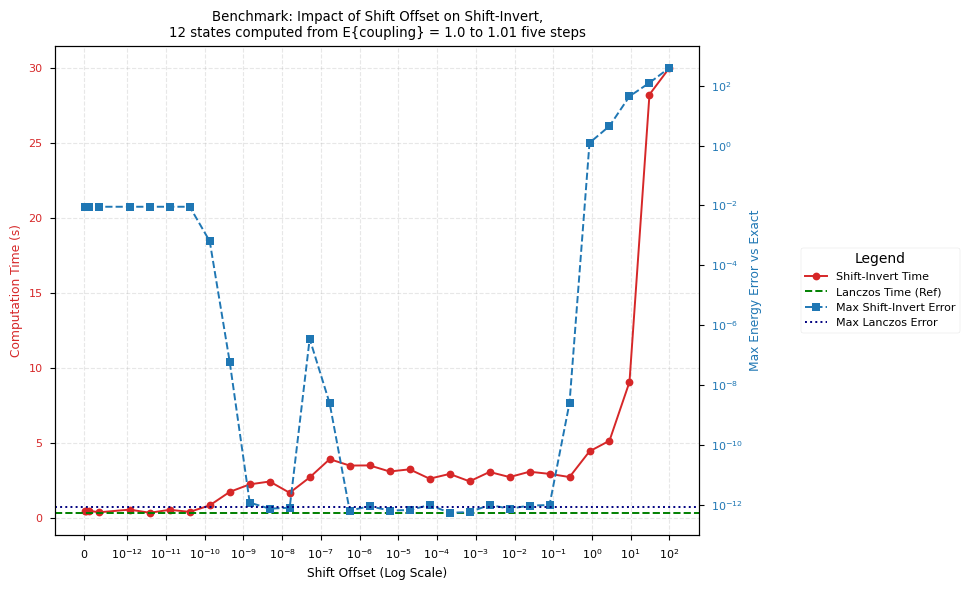

In [29]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 30
n_branches = 12
i=0
time_min_res = 0
residu_shift = []
residu_lanczos = []
iterations = []
ncv = []
niter = []

ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=300, osc_cut=30)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

coupling_list = np.linspace(1.0, 1.01, 5, dtype=np.float64)

# 0. EXACT DIAG (AJOUT POUR RÉFÉRENCE)
print("Calcul de référence (Exact Diag)...")
energies_exact, _ = get_values_exact_diagonalization(H_var_coupling_mat, n_branches, param_list=coupling_list)

# 1. LANCZOS
print("Calcul de référence (Lanczos)...")
start_l = time.perf_counter()
energies_ref, vectors_ref = get_values_Lanczos(H_var_coupling_mat, n_branches, param_list=coupling_list, tol=1e-8)
end_l = time.perf_counter()
time_lanczos = end_l - start_l
print(f"Lanczos terminé en {time_lanczos:.4f} s")

# Calcul de l'erreur Lanczos vs Exact (AJOUT)
# Gestion des dimensions : Lanczos est souvent (steps, branches), Exact est (branches, steps)
if energies_ref.shape != energies_exact.shape:
    diff_l = np.abs(energies_ref.T - energies_exact)
else:
    diff_l = np.abs(energies_ref - energies_exact)
max_err_lanczos = np.max(diff_l)
print(f"Erreur Max Lanczos vs Exact : {max_err_lanczos:.2e}")

# 2. BENCHMARK SHIFT
offsets = np.logspace(-14,2,32)
results_time = []
results_error_max = []
results_error_avg = []
results_iter_avg = []

print("\nDébut du benchmark Shift-Invert...")

for offset in offsets:
    # Reset des globales pour être propre
    iterations = [] 
    residu_shift = []
    time_min_res = 0
    
    # Appel de ta fonction (modifiée pour accepter shift_offset)
    start_si = time.perf_counter()
    E_si, V_si = get_values_shift_invert_real(
        H_var_coupling_mat, 
        n_branches, 
        param_list=coupling_list, 
        tol=1e-10,
        shift=offset,
        N_power = 4,
         tol_exit = 1e-7 # <--- Nouveau paramètre
    )
    end_si = time.perf_counter()
    
    total_time = end_si - start_si
    
    # --- METRIQUES ---
    
    # 1. Erreur sur l'énergie par rapport à EXACT (MODIFIÉ)
    # E_si et energies_exact ont normalement la même shape (branches, steps)
    if E_si.shape != energies_exact.shape:
         diff = np.abs(E_si.T - energies_exact)
    else:
         diff = np.abs(E_si - energies_exact)

    max_err = np.max(diff) # Le pire cas
    avg_err = np.mean(diff) # L'erreur moyenne
    
    # 2. Nombre moyen d'itérations minres
    avg_iter = np.mean(iterations) if iterations else 0
    
    print(f"Offset {offset:.1e} : Temps = {total_time:.2f}s | Max Err = {max_err:.2e} | Iter moy = {avg_iter:.1f}")
    
    results_time.append(total_time)
    results_error_max.append(max_err)
    results_iter_avg.append(avg_iter)

# --- PLOTS ---

# --- PLOTS ---

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- AXE 1 : TEMPS (Time) ---
color = 'tab:red'
ax1.set_xlabel('Shift Offset (Log Scale)')
ax1.set_ylabel('Computation Time (s)', color=color)
# On récupère les objets 'lines' pour la légende combinée
l1, = ax1.plot(offsets, results_time, marker='o', color=color, label='Shift-Invert Time')
l2 = ax1.axhline(y=time_lanczos, color='green', linestyle='--', label='Lanczos Time (Ref)')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('symlog', linthresh=1e-12)
ax1.grid(True, which='major', linestyle='--', alpha=0.3) # Petit bonus grille

# --- AXE 2 : ERREUR (Error) ---
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Max Energy Error vs Exact', color=color)  
# On récupère les objets 'lines' ici aussi
l3, = ax2.plot(offsets, results_error_max, marker='s', linestyle='--', color=color, label='Max Shift-Invert Error')
l4 = ax2.axhline(y=max_err_lanczos, color='navy', linestyle=':', label='Max Lanczos Error')

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

# --- LÉGENDE COMBINÉE EXTÉRIEURE ---
# On rassemble toutes les lignes et tous les labels
lines = [l1, l2, l3, l4]
labels = [l.get_label() for l in lines]

# On crée la légende sur ax1 (ou ax2, peu importe)
# bbox_to_anchor=(1.15, 0.5) place la boite à droite (x=1.15) et centrée verticalement (y=0.5)
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.15, 0.5), title="Legend")

plt.title(r"Benchmark: Impact of Shift Offset on Shift-Invert," + "\n" + 
          r"12 states computed from E{coupling} = 1.0 to 1.01 five steps")

# tight_layout est important ici pour redimensionner la figure et inclure la légende externe
fig.tight_layout()  
plt.show()

### Benchmark n_power and epsilon

Tracking de la branche 12 de 1.0 à 1.02
Pas de couplage : 0.0050
Pré-calcul des références exactes...


Benchmarking:   0%|          | 0/350 [00:00<?, ?it/s]

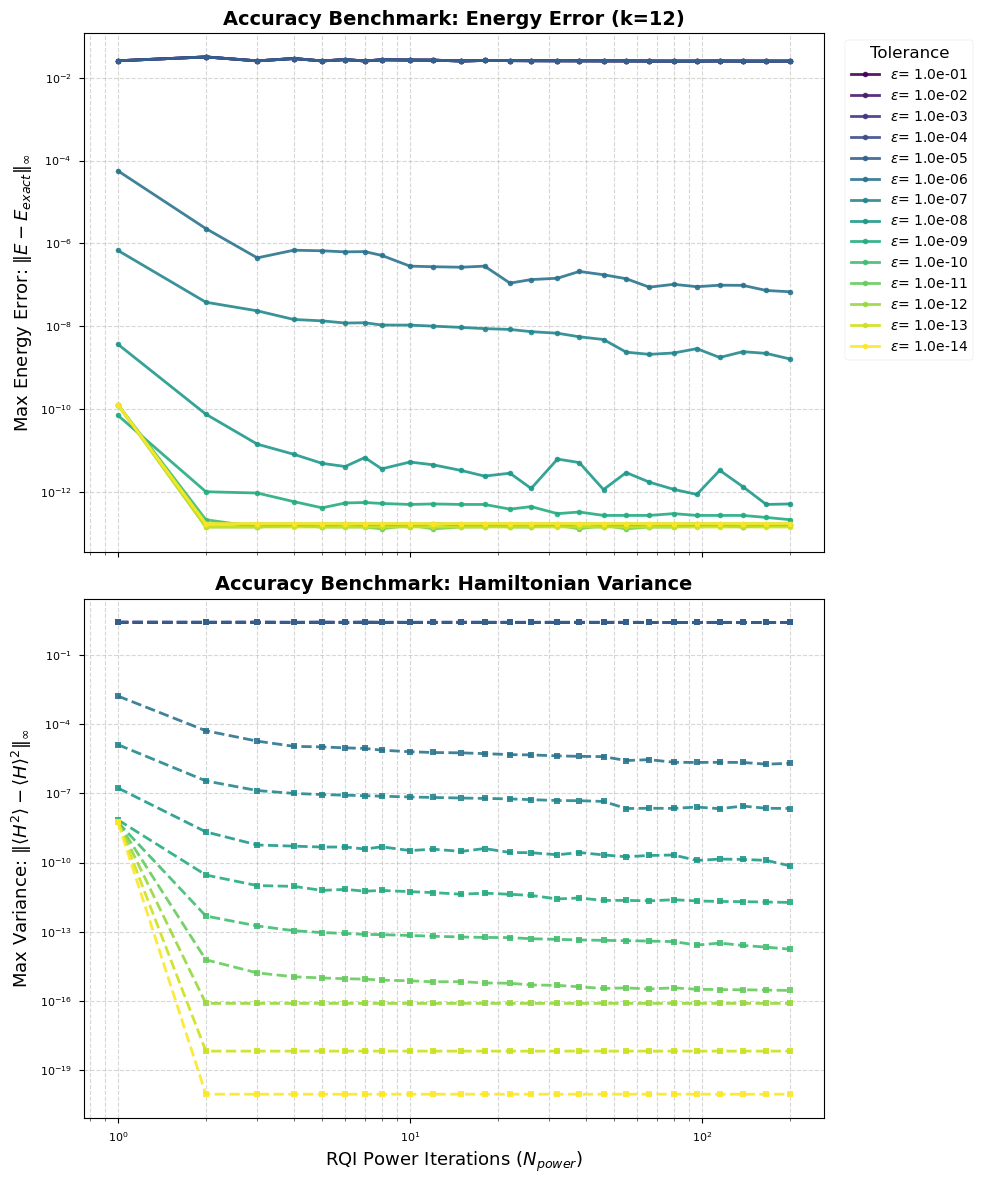

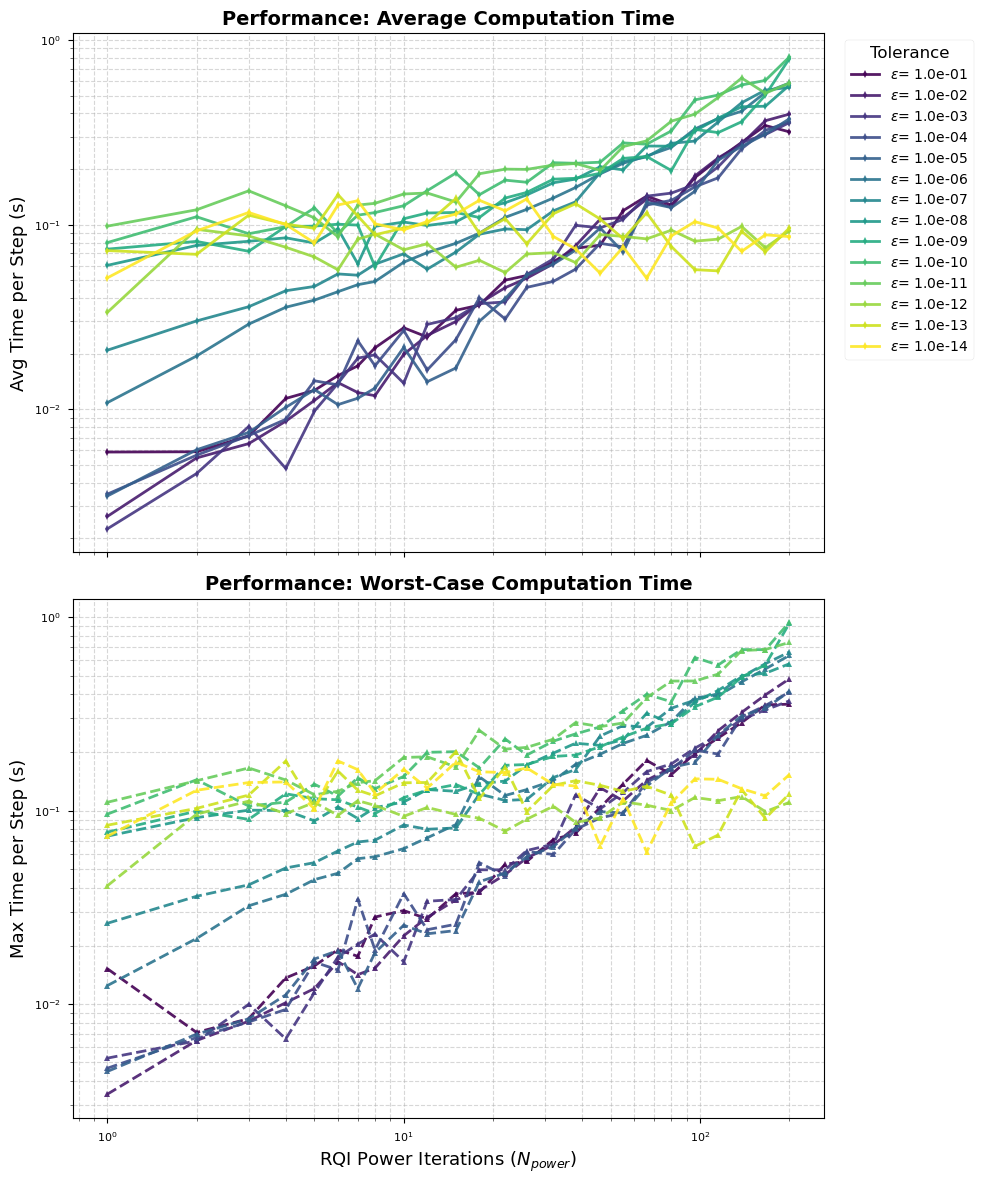

In [ ]:
# --- SETUP DU STYLE GRAPHIQUE ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'legend.fontsize': 10,
    'lines.linewidth': 2,
    'grid.alpha': 0.5,
    'grid.linestyle': '--'
})

# --- PARAMETRES ---
coupling_vals = np.linspace(1.0, 1.02, 5) 
target_k = 12
fixed_shift = 1e-4

EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 30
n_branches = 30

# Construction des opérateurs (Simulation des fonctions externes)
# Note: Assurez-vous que build_naked_operators_rotated et get_transmon_readout_matrix_explicit sont définis
ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=300, osc_cut=30)
H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit( 
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

print(f"Tracking de la branche {target_k} de {coupling_vals[0]} à {coupling_vals[-1]}")
print(f"Pas de couplage : {coupling_vals[1] - coupling_vals[0]:.4f}")

# --- PRE-CALCUL REFERENCE ---
exact_energies = []
Hs_list = []
initial_v = None

print("Pré-calcul des références exactes...")
for i, c in enumerate(coupling_vals):
    H = H_var_coupling_mat(c)
    Hs_list.append(H)
    
    if sp.issparse(H):
        H_dense = H.toarray()
    else:
        H_dense = H
    H_dense = (H_dense + H_dense.T) / 2
    
    evals, evecs = dense_linalg.eigh(H_dense)
    exact_energies.append(evals[target_k])
    
    if i == 0:
        initial_v = evecs[:, target_k]

# --- PARAMETRES BENCHMARK ---
N_power_list = np.unique(np.logspace(0, np.log10(200), 30, dtype=int))
tol_list = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14]

# Dictionnaires de résultats
results_error = {}
results_variance = {}
results_time_avg = {}
results_time_max = {}

total_iterations = len(tol_list) * len(N_power_list)
pbar = tqdm(total=total_iterations, desc="Benchmarking")

# --- BOUCLE PRINCIPALE ---
for tol_val in tol_list:
    # Listes temporaires pour ce tol_val
    max_errors_list = []
    max_variances_list = []
    avg_times_list = []
    max_times_list = []
    
    for N_val in N_power_list:
        v_current = initial_v.copy()
        current_max_error = 0.0
        current_max_variance = 0.0
        
        step_times = [] # Pour stocker les temps de chaque pas de la trajectoire
        
        for i in range(1, len(coupling_vals)):
            # Nettoyage des globales si nécessaire (dépend de votre implémentation interne)
            global iterations, residu_shift, time_min_res
            iterations = []
            residu_shift = []
            time_min_res = 0
            
            H_target = Hs_list[i]
            E_ref = exact_energies[i]
            
            # --- MESURE DU TEMPS ---
            t_start = time.perf_counter()
            E_calc, v_calc = shift_invert_step(
                H_target, 
                0, 
                v_current, 
                shift=fixed_shift, 
                tol=tol_val, 
                N_power=N_val
            )
            t_end = time.perf_counter()
            step_duration = t_end - t_start
            step_times.append(step_duration)
            # -----------------------
            
            # Calcul Erreur
            err = np.abs(E_calc - E_ref)
            if err > current_max_error:
                current_max_error = err
            
            # Calcul Variance
            res_vec = H_target @ v_calc - E_calc * v_calc
            variance = (np.linalg.norm(res_vec))**2
            if variance > current_max_variance:
                current_max_variance = variance
            
            v_current = v_calc
            
        # Stockage des métriques pour ce N_power
        max_errors_list.append(current_max_error)
        max_variances_list.append(current_max_variance)
        
        # Métriques temporelles (sur la trajectoire)
        if step_times:
            avg_times_list.append(np.mean(step_times))
            max_times_list.append(np.max(step_times))
        else:
            avg_times_list.append(0)
            max_times_list.append(0)

        pbar.update(1)
        
    # Enregistrement dans les dictionnaires globaux
    results_error[tol_val] = max_errors_list
    results_variance[tol_val] = max_variances_list
    results_time_avg[tol_val] = avg_times_list
    results_time_max[tol_val] = max_times_list

pbar.close()

# --- PLOTTING ---

# Palette de couleurs
colors = plt.cm.turbo(np.linspace(0, 1, len(tol_list)))

# FIGURE 1 : PRECISION (Physique)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot Erreur
for (tol_val, errors), color in zip(results_error.items(), colors):
    ax1.plot(N_power_list, errors, 'o-', label=r'$\epsilon$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax1.set_yscale('log')
ax1.set_ylabel(r'Max Energy Error: $\|E - E_{exact}\|_{\infty}$')
ax1.set_title(f'Accuracy Benchmark: Energy Error (k={target_k})', fontweight='bold')
ax1.grid(True, which="both")
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Tolerance")

# Plot Variance
for (tol_val, variances), color in zip(results_variance.items(), colors):
    ax2.plot(N_power_list, variances, 's--', label=r'$\epsilon$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'RQI Power Iterations ($N_{power}$)')
ax2.set_ylabel(r'Max Variance: $\|\langle H^2 \rangle - \langle H \rangle^2\|_{\infty}$')
ax2.set_title(f'Accuracy Benchmark: Hamiltonian Variance', fontweight='bold')
ax2.grid(True, which="both")

plt.tight_layout()
plt.show()

# FIGURE 2 : PERFORMANCE (Temps de calcul)
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot Temps Moyen
for (tol_val, times), color in zip(results_time_avg.items(), colors):
    ax3.plot(N_power_list, times, 'd-', label=r'$\epsilon$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax3.set_ylabel('Avg Time per Step (s)')
ax3.set_title(f'Performance: Average Computation Time', fontweight='bold')
ax3.set_yscale('log') # Log scale souvent utile pour le temps
ax3.grid(True, which="both")
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Tolerance")

# Plot Temps Max
for (tol_val, times), color in zip(results_time_max.items(), colors):
    ax4.plot(N_power_list, times, '^--', label=r'$\epsilon$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'RQI Power Iterations ($N_{power}$)')
ax4.set_ylabel('Max Time per Step (s)')
ax4.set_title(f'Performance: Worst-Case Computation Time', fontweight='bold')
ax4.grid(True, which="both")

plt.tight_layout()
plt.show()

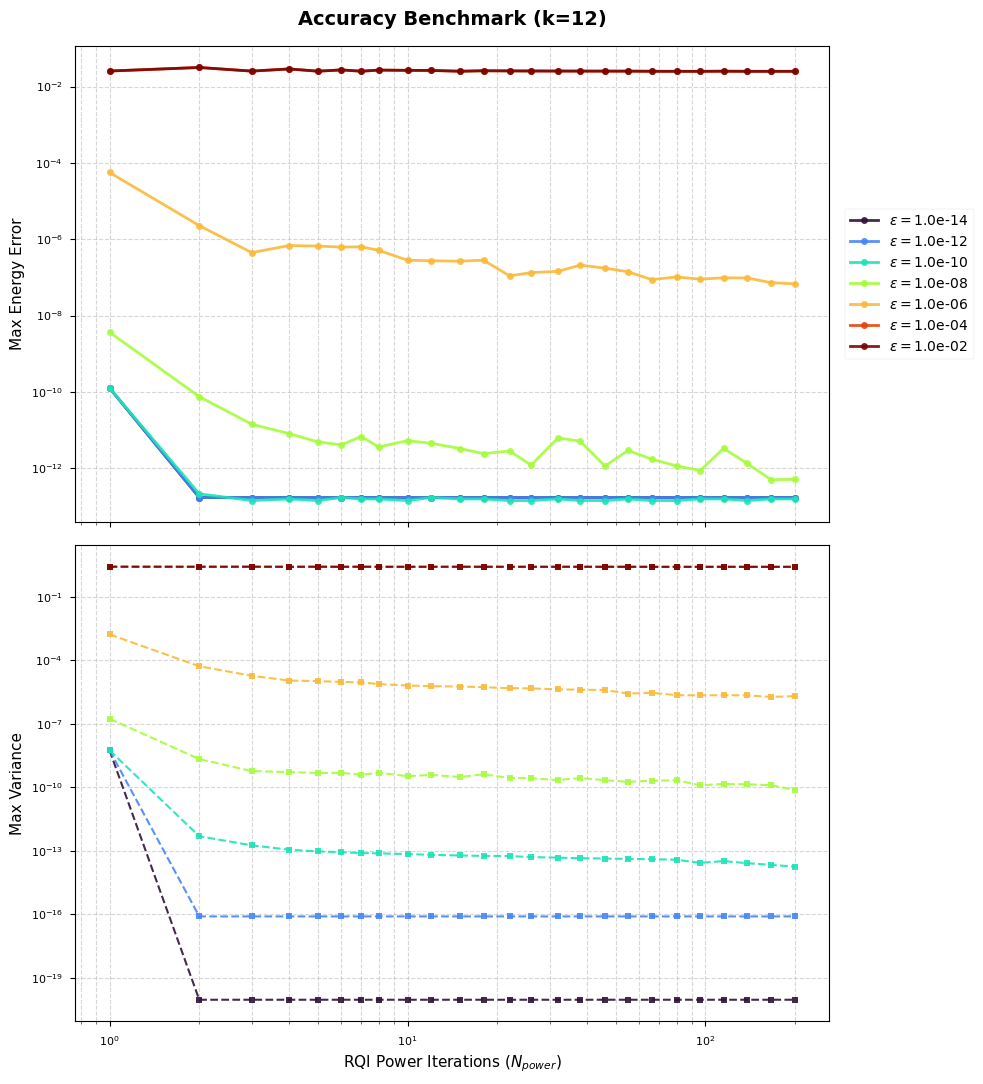

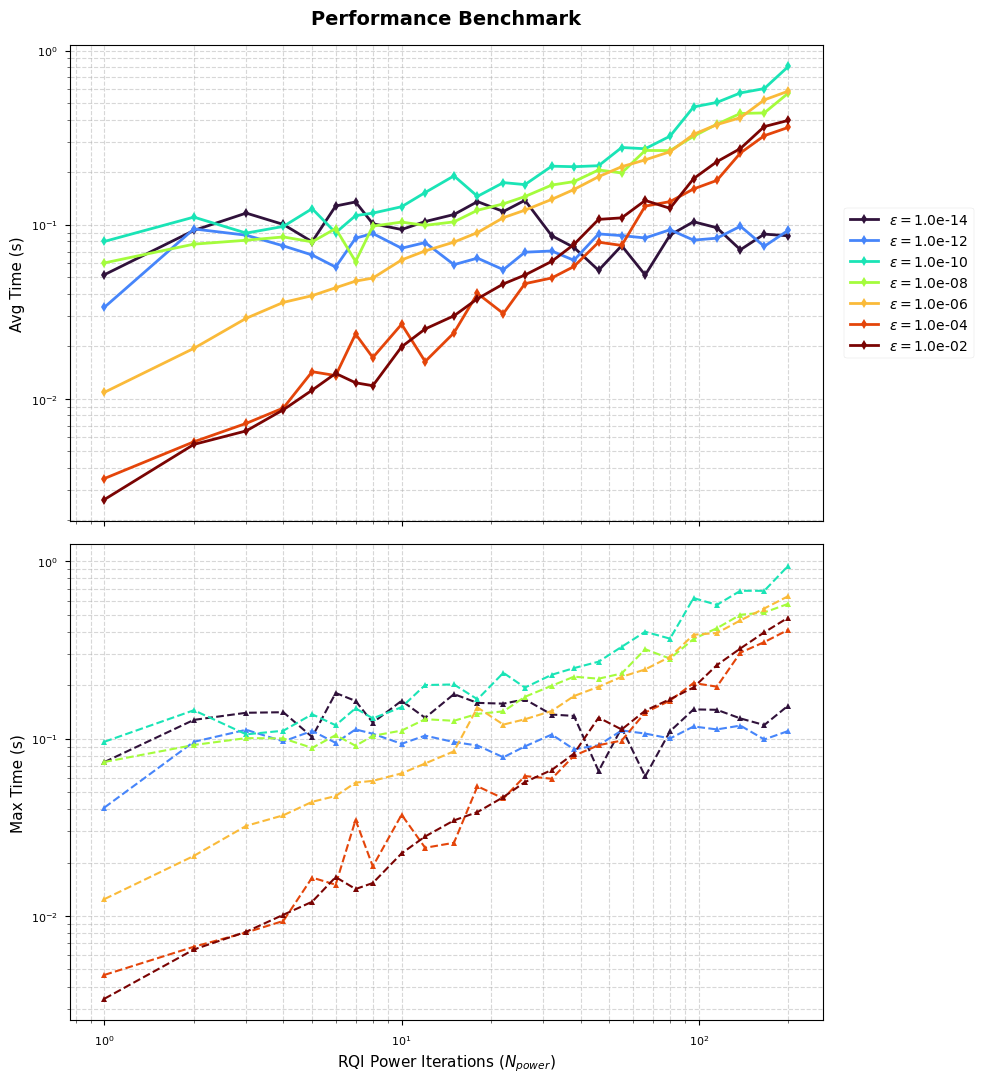

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Sélection rigoureuse de la moitié des données (1 sur 2)
# On prend les clés, on les trie, et on en garde une sur deux
sorted_tols = sorted(results_error.keys())
selected_tols = sorted_tols[::2] 

# 2. Nouvelle palette de couleurs dédiée uniquement aux courbes affichées
# Cela garantit d'avoir un vrai bleu au début et un vrai rouge à la fin
colors = plt.cm.turbo(np.linspace(0, 1, len(selected_tols)))

# --- FIGURE 1 : PRECISION ---
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

for tol_val, color in zip(selected_tols, colors):
    lbl = r"$\epsilon = $" + f"{tol_val:.1e}"
    
    # On ne trace que les données sélectionnées
    ax1.plot(N_power_list, results_error[tol_val], 'o-', 
             label=lbl, color=color, markersize=5, linewidth=2, alpha=0.9)
    
    ax2.plot(N_power_list, results_variance[tol_val], 's--', 
             label=lbl, color=color, markersize=5, linewidth=1.5, alpha=0.9)

# Esthétique Figure 1
ax1.set_yscale('log')
ax1.set_ylabel(r'Max Energy Error', fontsize=11)
ax1.set_title(f'Accuracy Benchmark (k={target_k})', fontweight='bold', pad=15)
ax1.grid(True, which="both", ls="--", alpha=0.5)
# Légende à droite, centrée verticalement par rapport à l'axe
ax1.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel(r'Max Variance', fontsize=11)
ax2.set_xlabel(r'RQI Power Iterations ($N_{power}$)', fontsize=11)
ax2.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# --- FIGURE 2 : PERFORMANCE ---
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

for tol_val, color in zip(selected_tols, colors):
    lbl = r"$\epsilon = $" + f"{tol_val:.1e}"
    
    ax3.plot(N_power_list, results_time_avg[tol_val], 'd-', 
             label=lbl, color=color, markersize=5, linewidth=2)
    
    ax4.plot(N_power_list, results_time_max[tol_val], '^--', 
             color=color, markersize=5, linewidth=1.5)

# Esthétique Figure 2
ax3.set_yscale('log')
ax3.set_ylabel('Avg Time (s)', fontsize=11)
ax3.set_title('Performance Benchmark', fontweight='bold', pad=15)
ax3.grid(True, which="both", ls="--", alpha=0.5)
ax3.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylabel('Max Time (s)', fontsize=11)
ax4.set_xlabel(r'RQI Power Iterations ($N_{power}$)', fontsize=11)
ax4.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Benchmark tol_exit

Tracking de la branche 12 (N_power=20)
Pré-calcul des références exactes...


Benchmarking tol_exit:   0%|          | 0/196 [00:00<?, ?it/s]

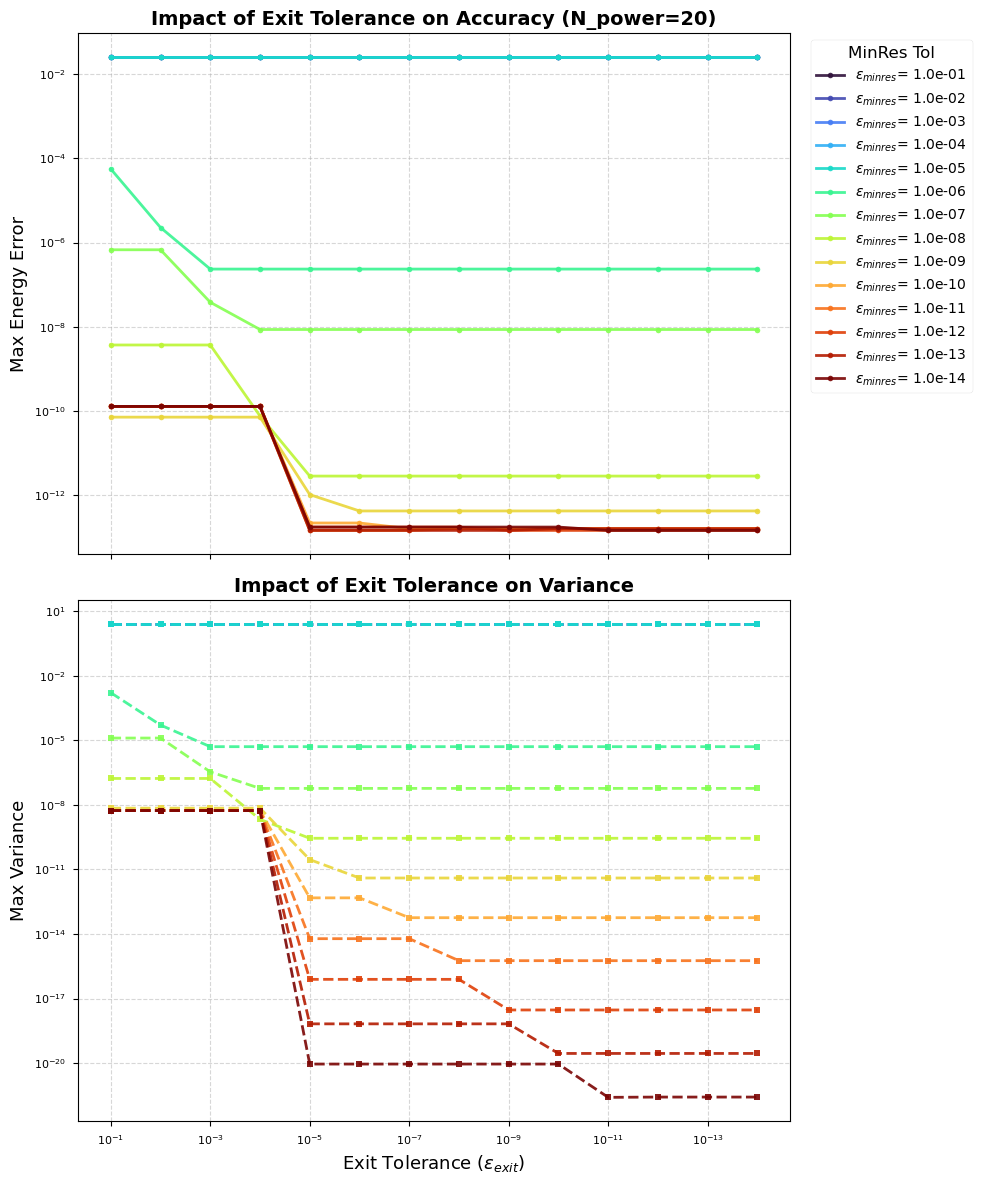

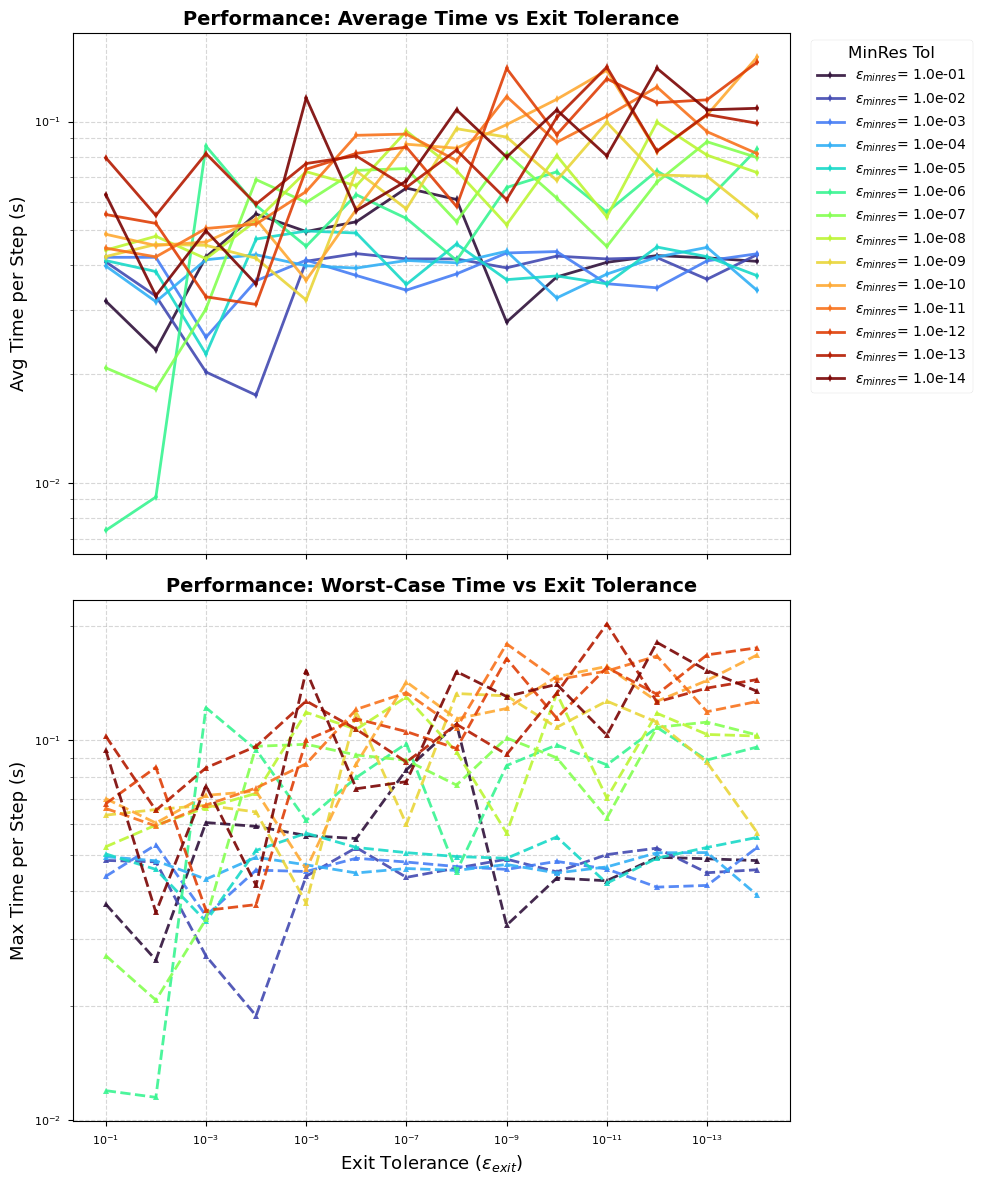

In [43]:
# --- PARAMETRES ---
coupling_vals = np.linspace(1.0, 1.02, 5) 
target_k = 12
fixed_shift = 1e-5
N_power_fixed = 20 # Fixé comme demandé

# --- PRE-CALCUL REFERENCE (Inchangé) ---
# Je suppose que ops_data et les Hamiltoniens sont déjà en mémoire ou recréés ici
# Pour la cohérence du script, je réutilise les blocs précédents si nécessaire
# (Je saute la création explicite des opérateurs pour aller droit au benchmark)

print(f"Tracking de la branche {target_k} (N_power={N_power_fixed})")

# Si besoin de recalculer les références (décommenter si c'est un nouveau run)
exact_energies = []
Hs_list = []
initial_v = None

print("Pré-calcul des références exactes...")
for i, c in enumerate(coupling_vals):
    H = H_var_coupling_mat(c)
    Hs_list.append(H)
    
    if sp.issparse(H): H_dense = H.toarray()
    else: H_dense = H
    H_dense = (H_dense + H_dense.T) / 2
    
    evals, evecs = dense_linalg.eigh(H_dense)
    exact_energies.append(evals[target_k])
    if i == 0: initial_v = evecs[:, target_k]

# --- PARAMETRES BENCHMARK ---
# AXE X : tol_exit (Critère d'arrêt de la boucle RQI)
# Variation de 1e-1 à 1e-14
tol_exit_list = np.logspace(-1, -14, 14) 

# COULEURS : tol (Tolérance du solveur minres)
# On garde la même liste pour comparer les courbes
tol_minres_list = np.logspace(-1,-14,14)

# Dictionnaires de résultats
results_error = {}
results_variance = {}
results_time_avg = {}
results_time_max = {}

total_iterations = len(tol_minres_list) * len(tol_exit_list)
pbar = tqdm(total=total_iterations, desc="Benchmarking tol_exit")

# --- BOUCLE PRINCIPALE ---
for tol_val in tol_minres_list: # Boucle sur les couleurs (MinRes precision)
    
    max_errors_list = []
    max_variances_list = []
    avg_times_list = []
    max_times_list = []
    
    for exit_val in tol_exit_list: # Boucle sur l'axe X (Exit criterion)
        
        v_current = initial_v.copy()
        current_max_error = 0.0
        current_max_variance = 0.0
        step_times = [] 
        
        for i in range(1, len(coupling_vals)):
            # Reset globales
            global iterations, residu_shift, time_min_res
            iterations = []
            residu_shift = []
            time_min_res = 0
            
            H_target = Hs_list[i]
            E_ref = exact_energies[i]
            
            # --- MESURE ---
            t_start = time.perf_counter()
            E_calc, v_calc = shift_invert_step(
                H_target, 
                0, 
                v_current, 
                shift=fixed_shift, 
                tol=tol_val,       # Précision du solveur (interne)
                N_power=N_power_fixed, # Fixé à 6
                tol_exit=exit_val  # Condition de sortie (externe)
            )
            t_end = time.perf_counter()
            step_times.append(t_end - t_start)
            # -------------
            
            # Erreur
            err = np.abs(E_calc - E_ref)
            if err > current_max_error: current_max_error = err
            
            # Variance
            res_vec = H_target @ v_calc - E_calc * v_calc
            variance = (np.linalg.norm(res_vec))**2
            if variance > current_max_variance: current_max_variance = variance
            
            v_current = v_calc
            
        # Stockage
        max_errors_list.append(current_max_error)
        max_variances_list.append(current_max_variance)
        if step_times:
            avg_times_list.append(np.mean(step_times))
            max_times_list.append(np.max(step_times))
        else:
            avg_times_list.append(0)
            max_times_list.append(0)

        pbar.update(1)
        
    # Enregistrement
    results_error[tol_val] = max_errors_list
    results_variance[tol_val] = max_variances_list
    results_time_avg[tol_val] = avg_times_list
    results_time_max[tol_val] = max_times_list

pbar.close()

# --- PLOTTING ---
# On inverse l'axe X pour avoir la tolérance la plus stricte (1e-14) à droite ou à gauche selon préférence
# Standard : 1e-14 à gauche, 1e-1 à droite.

colors = plt.cm.turbo(np.linspace(0, 1, len(tol_minres_list)))

# FIGURE 1 : PRECISION
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Erreur
for (tol_val, errors), color in zip(results_error.items(), colors):
    ax1.plot(tol_exit_list, errors, 'o-', label=r'$\epsilon_{minres}$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'Max Energy Error')
ax1.set_title(f'Impact of Exit Tolerance on Accuracy (N_power={N_power_fixed})', fontweight='bold')
ax1.grid(True, which="both")
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="MinRes Tol")
# Optionnel : Inverser l'axe X pour avoir "plus strict" vers la droite
ax1.invert_xaxis() 

# Variance
for (tol_val, variances), color in zip(results_variance.items(), colors):
    ax2.plot(tol_exit_list, variances, 's--', label=r'$\epsilon_{minres}$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Exit Tolerance ($\epsilon_{exit}$)')
ax2.set_ylabel(r'Max Variance')
ax2.set_title(f'Impact of Exit Tolerance on Variance', fontweight='bold')
ax2.grid(True, which="both")
# ax2.invert_xaxis() # Si on veut inverser ici aussi (automatique via sharex normalement)

plt.tight_layout()
plt.show()

# FIGURE 2 : PERFORMANCE
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Temps Moyen
for (tol_val, times), color in zip(results_time_avg.items(), colors):
    ax3.plot(tol_exit_list, times, 'd-', label=r'$\epsilon_{minres}$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylabel('Avg Time per Step (s)')
ax3.set_title(f'Performance: Average Time vs Exit Tolerance', fontweight='bold')
ax3.grid(True, which="both")
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="MinRes Tol")
ax3.invert_xaxis()

# Temps Max
for (tol_val, times), color in zip(results_time_max.items(), colors):
    ax4.plot(tol_exit_list, times, '^--', label=r'$\epsilon_{minres}$' + f'= {tol_val:.1e}', color=color, markersize=4, alpha=0.9)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'Exit Tolerance ($\epsilon_{exit}$)')
ax4.set_ylabel('Max Time per Step (s)')
ax4.set_title(f'Performance: Worst-Case Time vs Exit Tolerance', fontweight='bold')
ax4.grid(True, which="both")

plt.tight_layout()
plt.show()

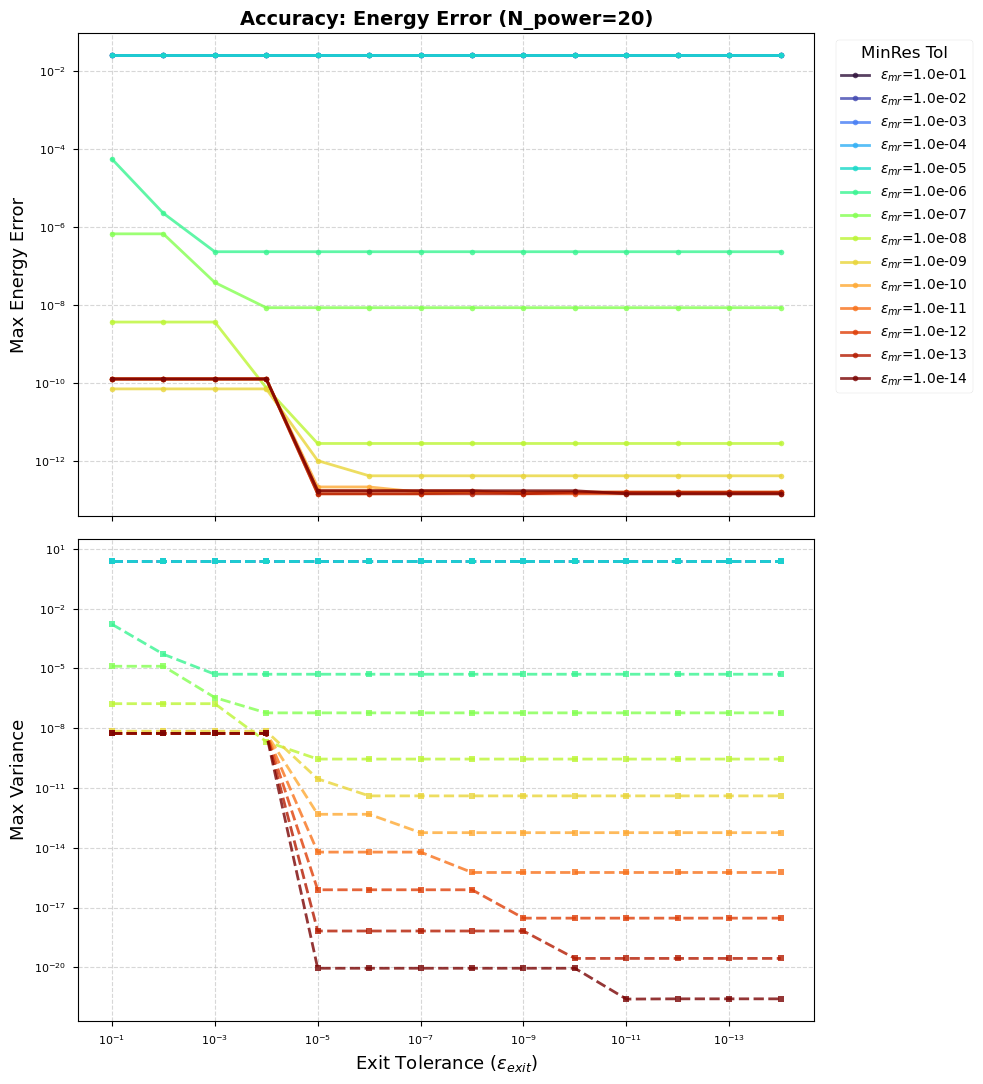

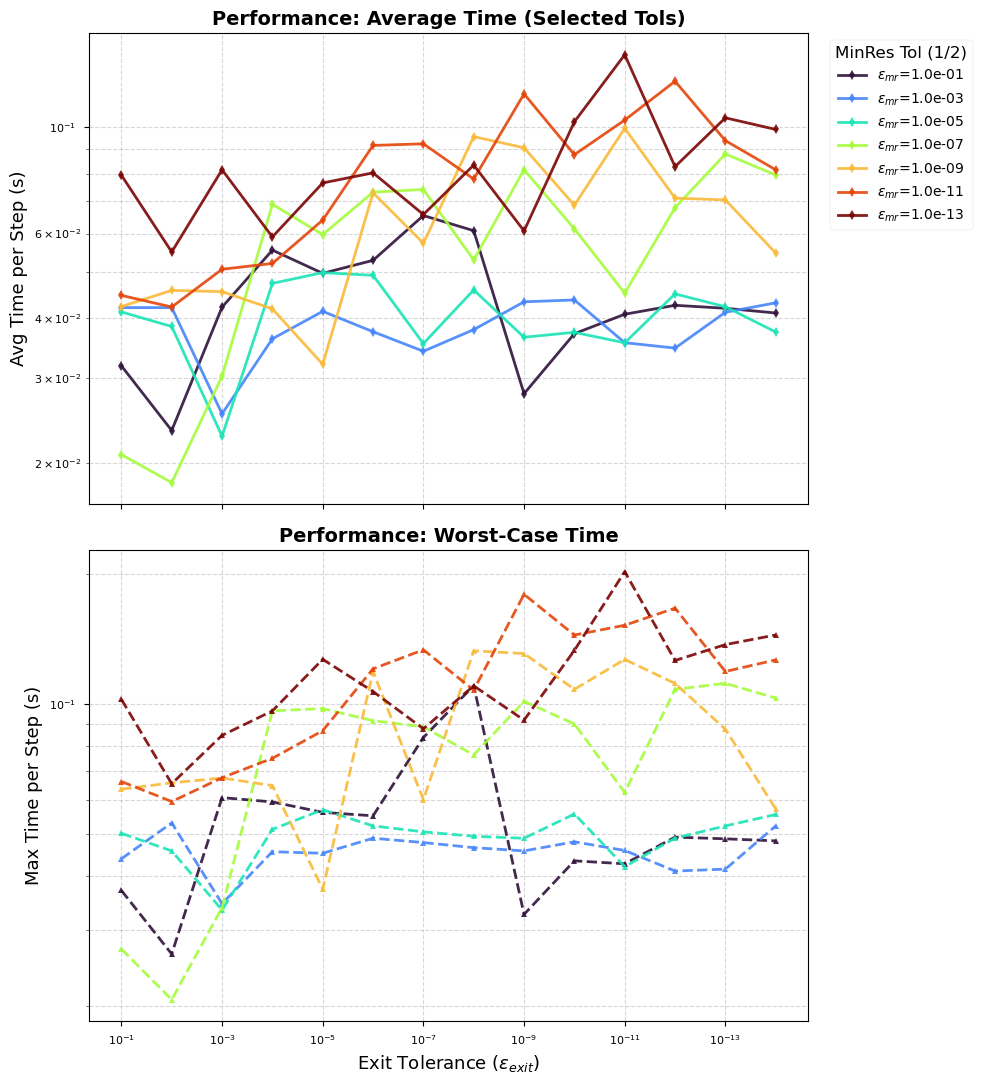

In [45]:
# --- PLOTTING ---
# On prépare deux listes de couleurs : une complète, une réduite
colors_full = plt.cm.turbo(np.linspace(0, 1, len(tol_minres_list)))

# Pour la performance, on filtre : une tolérance sur deux
selected_tols_perf = list(results_time_avg.keys())[::2]
colors_perf = plt.cm.turbo(np.linspace(0, 1, len(selected_tols_perf)))

# FIGURE 1 : PRECISION (Toutes les courbes)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

for (tol_val, errors), color in zip(results_error.items(), colors_full):
    ax1.plot(tol_exit_list, errors, 'o-', label=r'$\epsilon_{mr}$' + f'={tol_val:.1e}', 
             color=color, markersize=4, alpha=0.8)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'Max Energy Error')
ax1.set_title(f'Accuracy: Energy Error (N_power={N_power_fixed})', fontweight='bold')
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="MinRes Tol", fontsize='small')
ax1.invert_xaxis() 

for (tol_val, variances), color in zip(results_variance.items(), colors_full):
    ax2.plot(tol_exit_list, variances, 's--', color=color, markersize=4, alpha=0.8)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Exit Tolerance ($\epsilon_{exit}$)')
ax2.set_ylabel(r'Max Variance')
ax2.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# FIGURE 2 : PERFORMANCE (Une courbe sur deux pour éviter l'effet "barre")
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

# On boucle uniquement sur les tolérances sélectionnées pour la performance
for tol_val, color in zip(selected_tols_perf, colors_perf):
    
    # Plot Temps Moyen (Plot 3)
    ax3.plot(tol_exit_list, results_time_avg[tol_val], 'd-', 
             label=r'$\epsilon_{mr}$' + f'={tol_val:.1e}', color=color, markersize=5, alpha=0.9)
    
    # Plot Temps Max (Plot 4)
    ax4.plot(tol_exit_list, results_time_max[tol_val], '^--', 
             color=color, markersize=5, alpha=0.9)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylabel('Avg Time per Step (s)')
ax3.set_title(f'Performance: Average Time (Selected Tols)', fontweight='bold')
ax3.grid(True, which="both", ls="--", alpha=0.5)
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="MinRes Tol (1/2)")
ax3.invert_xaxis()

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'Exit Tolerance ($\epsilon_{exit}$)')
ax4.set_ylabel('Max Time per Step (s)')
ax4.set_title(f'Performance: Worst-Case Time', fontweight='bold')
ax4.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Benchmark n_states

In [ ]:
coupling_list_bench = np.linspace(1.0, 1.05, 3, dtype=np.float64) 
n_branches_bench = 60         

print("Pré-calcul de la référence...")
exact_energies_ref, exact_vectors_ref = get_values_exact_diagonalization(
    H_var_coupling_mat, 
    n_branches_bench, 
    coupling_list_bench
)
print("Fait.")

In [48]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 50
tol_val = 1e-7
tol_exit = 1e-7
shift_val = 1e-5
N_power = 5

# --- 2. SETUP HAMILTONIEN ---
ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=50)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit( 
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

coupling_list = np.linspace(1.0, 1.01, 4, dtype=np.float64)
n_states_list = [5, 10, 25, 50, 75, 100]

# --- 3. PRÉ-CALCUL RÉFÉRENCE (EXACT DIAG) ---
print("Calcul de la référence (Exact Diag)...")
exact_energies_list = []
Hs_list = [] # On garde les matrices pour le calcul de variance plus tard

for c in coupling_list:
    H = H_var_coupling_mat(c)
    Hs_list.append(H)
    
    # Conversion Dense pour référence absolue
    if sp.issparse(H): H_dense = H.toarray()
    else: H_dense = H
    H_dense = (H_dense + H_dense.T) / 2
    
    evals, _ = dense_linalg.eigh(H_dense)
    exact_energies_list.append(evals)

exact_energies_arr = np.array(exact_energies_list) # Shape: (n_steps, n_total_states)


# --- 4. BOUCLE DE BENCHMARK ---
results = {
    'lanczos': {'time': [], 'error': [], 'variance': []},
    'si':      {'time': [], 'error': [], 'variance': []}
}

print(f"Démarrage du benchmark complet (Time/Error/Variance)...")

for n_st in tqdm(n_states_list, desc="Benchmark"):
    
    # === LANCZOS ===
    start_l = time.perf_counter()
    E_lan, V_lan = get_values_Lanczos(
        H_var_coupling_mat, n_st, param_list=coupling_list, tol=tol_val
    )
    results['lanczos']['time'].append(time.perf_counter() - start_l)
    
    # Erreur Lanczos
    # On compare les n_st premiers états calculés aux n_st exacts
    # Attention aux dimensions: E_lan est souvent (steps, states)
    if E_lan.shape[0] != len(coupling_list): E_lan = E_lan.T 
    
    err_l = np.abs(E_lan - exact_energies_arr[:, :n_st])
    results['lanczos']['error'].append(np.max(err_l))
    
    # Variance Lanczos (Max sur tous les steps et tous les états)
    max_var_l = 0.0
    for i, H_op in enumerate(Hs_list):
        vecs = V_lan[i] # Shape attendue (n_st, dim) ou (dim, n_st)
        if vecs.shape[0] != H_op.shape[0]: vecs = vecs.T
        # Variance = ||H*v - E*v||^2
        res = np.linalg.norm(H_op @ vecs - vecs * E_lan[i], axis=0)**2
        max_var_l = max(max_var_l, np.max(res))
    results['lanczos']['variance'].append(max_var_l)


    # === SHIFT-INVERT ===
    start_si = time.perf_counter()
    E_si, V_si = get_values_shift_invert_real(
        H_var_coupling_mat, n_st, param_list=coupling_list, 
        tol=tol_val, shift=shift_val, tol_exit=tol_exit, 
        # N_power=N_power # (Si ta fonction accepte N_power en argument direct)
    )
    results['si']['time'].append(time.perf_counter() - start_si)
    
    # Erreur Shift-Invert
    if E_si.shape[0] != len(coupling_list): E_si = E_si.T
    err_si = np.abs(E_si - exact_energies_arr[:, :n_st])
    results['si']['error'].append(np.max(err_si))
    
    # Variance Shift-Invert
    max_var_si = 0.0
    for i, H_op in enumerate(Hs_list):
        vecs = V_si[i]
        if vecs.shape[0] != H_op.shape[0]: vecs = vecs.T
        res = np.linalg.norm(H_op @ vecs - vecs * E_si[i], axis=0)**2
        max_var_si = max(max_var_si, np.max(res))
    results['si']['variance'].append(max_var_si)


# --- 5. TRACÉ ---
plt.style.use('seaborn-v0_8-paper')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12), sharex=True, dpi=120)

# AXE 1 : TEMPS
ax1.plot(n_states_list, results['lanczos']['time'], 's-', color='#E63946', label='Lanczos')
ax1.plot(n_states_list, results['si']['time'], 'o--', color='#1D3557', label='Shift-Invert')
ax1.set_ylabel('Time (s)', fontweight='bold')
ax1.set_title(f'Performance Benchmark (Coupling Steps: {len(coupling_list)})', fontweight='bold')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend()

# AXE 2 : ERREUR MAX
ax2.plot(n_states_list, results['lanczos']['error'], 's-', color='#E63946', label='Lanczos')
ax2.plot(n_states_list, results['si']['error'], 'o--', color='#1D3557', label='Shift-Invert')
ax2.axhline(y=tol_val, color='gray', linestyle=':', label='Target Tol')
ax2.set_ylabel(r'Max Error $\|E - E_{exact}\|_{\infty}$', fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, linestyle=':', alpha=0.6)

# AXE 3 : VARIANCE MAX
ax3.plot(n_states_list, results['lanczos']['variance'], 's-', color='#E63946', label='Lanczos')
ax3.plot(n_states_list, results['si']['variance'], 'o--', color='#1D3557', label='Shift-Invert')
ax3.set_ylabel(r'Max Variance $\|\langle H^2 \rangle - \langle H \rangle^2\|_{\infty}$', fontweight='bold')
ax3.set_xlabel('Number of Target States (k)', fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

Calcul de la référence (Exact Diag)...
Démarrage du benchmark complet (Time/Error/Variance)...


Benchmark:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (2500,4) (5,) 

### Benchmark Lanczos only

Dimension Hilbert : 3600
1. Calcul de la référence (Exact Diag)...


Reference: 100%|██████████| 6/6 [01:46<00:00, 17.75s/it]



2. Démarrage du benchmark Comparatif...


Benchmarking: 100%|██████████| 6/6 [27:09<00:00, 271.56s/it]


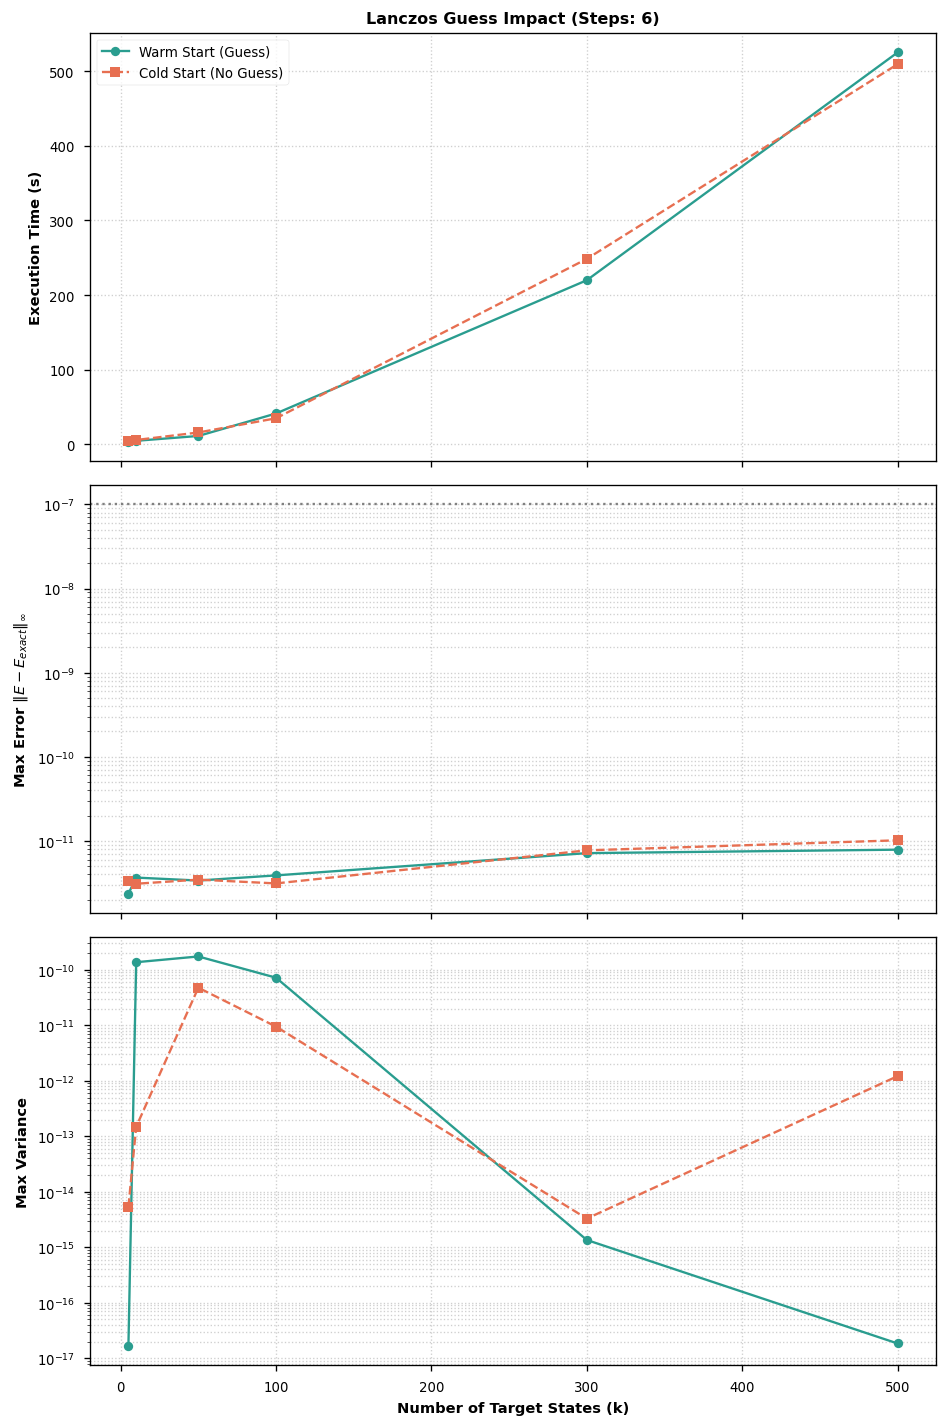

In [23]:
# --- 2. PARAMÈTRES ---
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 60
tol_val = 1e-7

# Setup Hamiltonien
# (Je suppose que tes fonctions de construction sont disponibles)
ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=60)
H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit( 
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

# Paramètres du benchmark
coupling_list = np.linspace(1.0, 1.01, 6, dtype=np.float64)
n_states_list = [5, 10,50,100,300,500] 

# --- 3. PRÉ-CALCUL RÉFÉRENCE (EXACT DIAG) ---
print(f"Dimension Hilbert : {n_transmon_keep * 60}")
print("1. Calcul de la référence (Exact Diag)...")

exact_energies_list = []
Hs_list = [] 

for c in tqdm(coupling_list, desc="Reference"):
    H = H_var_coupling_mat(c)
    Hs_list.append(H)
    
    if sp.issparse(H): H_dense = H.toarray()
    else: H_dense = H
    H_dense = (H_dense + H_dense.T) / 2
    
    evals, _ = dense_linalg.eigh(H_dense)
    exact_energies_list.append(evals)

exact_energies_arr = np.array(exact_energies_list)

# --- 4. BOUCLE DE BENCHMARK ---
results = {
    'warm': {'time': [], 'error': [], 'variance': []},
    'cold': {'time': [], 'error': [], 'variance': []}
}

print(f"\n2. Démarrage du benchmark Comparatif...")

for n_st in tqdm(n_states_list, desc="Benchmarking"):
    
    # --- A. LANCZOS WARM START (Standard) ---
    start = time.perf_counter()
    E_w, V_w = get_values_Lanczos(H_var_coupling_mat, n_st, coupling_list, tol_val)
    results['warm']['time'].append(time.perf_counter() - start)
    
    # Erreur & Variance Warm
    if E_w.shape[0] != len(coupling_list): E_w = E_w.T
    err_w = np.max(np.abs(E_w - exact_energies_arr[:, :n_st]))
    results['warm']['error'].append(err_w)
    
    max_var_w = 0.0
    for i, H_op in enumerate(Hs_list):
        vecs = V_w[i]
        if vecs.shape[0] != H_op.shape[0]: vecs = vecs.T
        res = np.linalg.norm(H_op @ vecs - vecs * E_w[i], axis=0)**2
        max_var_w = max(max_var_w, np.max(res))
    results['warm']['variance'].append(max_var_w)

    # --- B. LANCZOS COLD START (No Guess) ---
    start = time.perf_counter()
    E_c, V_c = get_values_Lanczos_no_guess(H_var_coupling_mat, n_st, coupling_list, tol_val)
    results['cold']['time'].append(time.perf_counter() - start)
    
    # Erreur & Variance Cold
    if E_c.shape[0] != len(coupling_list): E_c = E_c.T
    err_c = np.max(np.abs(E_c - exact_energies_arr[:, :n_st]))
    results['cold']['error'].append(err_c)
    
    max_var_c = 0.0
    for i, H_op in enumerate(Hs_list):
        vecs = V_c[i]
        if vecs.shape[0] != H_op.shape[0]: vecs = vecs.T
        res = np.linalg.norm(H_op @ vecs - vecs * E_c[i], axis=0)**2
        max_var_c = max(max_var_c, np.max(res))
    results['cold']['variance'].append(max_var_c)

# --- 5. PLOTS ---
plt.style.use('seaborn-v0_8-paper')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12), sharex=True, dpi=120)

# AXE 1 : TEMPS
ax1.plot(n_states_list, results['warm']['time'], 'o-', color='#2A9D8F', label='Warm Start (Guess)')
ax1.plot(n_states_list, results['cold']['time'], 's--', color='#E76F51', label='Cold Start (No Guess)')
ax1.set_ylabel('Execution Time (s)', fontweight='bold')
ax1.set_title(f'Lanczos Guess Impact (Steps: {len(coupling_list)})', fontweight='bold')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend()

# AXE 2 : ERREUR MAX
ax2.plot(n_states_list, results['warm']['error'], 'o-', color='#2A9D8F', label='Error Warm')
ax2.plot(n_states_list, results['cold']['error'], 's--', color='#E76F51', label='Error Cold')
ax2.axhline(y=tol_val, color='gray', linestyle=':', label='Tol')
ax2.set_ylabel(r'Max Error $\|E - E_{exact}\|_{\infty}$', fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, linestyle=':', alpha=0.6, which='both')
# ax2.legend() # Légende souvent redondante si les couleurs sont claires, à toi de voir

# AXE 3 : VARIANCE MAX
ax3.plot(n_states_list, results['warm']['variance'], 'o-', color='#2A9D8F', label='Variance Warm')
ax3.plot(n_states_list, results['cold']['variance'], 's--', color='#E76F51', label='Variance Cold')
ax3.set_ylabel(r'Max Variance', fontweight='bold')
ax3.set_xlabel('Number of Target States (k)', fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, linestyle=':', alpha=0.6, which='both')
# ax3.legend()

plt.tight_layout()
plt.show()

In [2]:
plt.style.use('seaborn-v0_8-paper')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 14), sharex=True)

# PLOT 1 : TEMPS
ax1.plot(n_states_list, results['t_l'], 's-', label='Lanczos', color='#E63946', markersize=6)
ax1.plot(n_states_list, results['t_si'], 'o--', label='Shift-Invert', color='#1D3557', markersize=6)
ax1.set_ylabel('Total Time (s)', fontweight='bold')
ax1.set_title('Time vs Number of States', fontsize=12)
ax1.legend()
ax1.grid(True, ls=':')

# PLOT 2 : ERREUR D'ÉNERGIE (Log scale)
ax2.plot(n_states_list, results['err_l'], 's-', color='#E63946')
ax2.plot(n_states_list, results['err_si'], 'o--', color='#1D3557')
ax2.set_yscale('log')
ax2.set_ylabel(r'Max Energy Error $\Delta E$', fontweight='bold')
ax2.set_title('Absolute Accuracy', fontsize=12)
ax2.grid(True, which="both", ls=':')

# PLOT 3 : VARIANCE (Log scale)
ax3.plot(n_states_list, results['var_l'], 's-', color='#E63946')
ax3.plot(n_states_list, results['var_si'], 'o--', color='#1D3557')
ax3.set_yscale('log')
ax3.set_ylabel(r'Max Variance $\sigma^2$', fontweight='bold')
ax3.set_xlabel('Number of Target States ($n_{st}$)', fontsize=11)
ax3.set_title('Intrinsic Quality (Residual Norm)', fontsize=12)
ax3.grid(True, which="both", ls=':')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PRÉPARATION DES DONNÉES ---

# On s'assure que E_lan est dans le bon sens (n_steps, n_states)
if E_lan.shape[0] != len(coupling_list):
    E_lan = E_lan.T

# Dimensions actuelles
n_steps, n_computed = E_lan.shape

# On sélectionne les 10 derniers indices calculés
n_zoom = 10
start_idx = max(0, n_computed - n_zoom)
indices_zoom = np.arange(start_idx, n_computed)

print(f"Visualisation des états k={indices_zoom[0]} à {indices_zoom[-1]} sur {n_steps} points de couplage.")

# --- 2. TRACÉ ---
plt.style.use('seaborn-v0_8-paper')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, dpi=120)

# --- PLOT 1 : ÉVOLUTION DES ÉNERGIES (SPECTRE) ---
# On boucle sur chaque état k sélectionné
for i, k in enumerate(indices_zoom):
    # Récupération des trajectoires
    traj_exact = exact_energies_arr[:, k]
    traj_lan = E_lan[:, k]
    
    # Gestion de la légende (on ne l'affiche qu'une fois pour ne pas polluer)
    label_exact = "Exact Diag" if i == 0 else "_nolegend_"
    label_lan = "Lanczos" if i == 0 else "_nolegend_"
    
    # Tracé Exact (Ligne continue noire/grise)
    ax1.plot(coupling_list, traj_exact, color='black', alpha=0.5, linewidth=2, label=label_exact)
    
    # Tracé Lanczos (Pointillés rouges ou croix)
    ax1.plot(coupling_list, traj_lan, color='#E63946', linestyle='--', marker='x', 
             markersize=6, linewidth=1.5, label=label_lan)

ax1.set_ylabel('Energy')
ax1.set_title(f'Top {n_zoom} Energy Levels Evolution (States k={indices_zoom[0]}-{indices_zoom[-1]})', fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

# --- PLOT 2 : ÉVOLUTION DE L'ERREUR ---
# On trace l'erreur pour chaque branche
for i, k in enumerate(indices_zoom):
    traj_exact = exact_energies_arr[:, k]
    traj_lan = E_lan[:, k]
    error = np.abs(traj_lan - traj_exact)
    
    ax2.plot(coupling_list, error, 'o-', markersize=4, alpha=0.8, label=f'k={k}')

# Ligne de tolérance
ax2.axhline(y=tol_val, color='gray', linestyle='--', linewidth=1.5, label=f'Tol ({tol_val})')

ax2.set_xlabel('Coupling Parameter')
ax2.set_ylabel(r'Absolute Error $|E_{lan} - E_{exact}|$')
ax2.set_yscale('log')
ax2.set_title('Stability Check: Error per Branch vs Coupling', fontweight='bold')

# Légende compacte à droite pour identifier quelle branche pose problème
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="State Index", fontsize='small')
ax2.grid(True, which='both', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

NameError: name 'E_lan' is not defined

### On complex hamiltonians

In [ ]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 25
osc_cut = 50

ops_data_complex = build_naked_operators(EJ_val, EC_T_val, n_transmon_keep, n_cut=300, osc_cut=osc_cut)

H_var_coupling = lambda E_coupling: get_transmon_readout_hamiltonian(  # noqa: E731
    ops_data_complex, EC_R_val, EL_R_val, E_coupling=E_coupling
)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data_complex, EC_R_val, EL_R_val, E_coupling=E_coupling
)


coupling_list = np.linspace(0.0, 0.6, 80, dtype=np.float64)

start_si_opt_c = time.perf_counter()
energies_si_opt_c, vectors_si_opt_c = get_values_shift_invert_complex(H_var_coupling, n_branches=3, param_list=coupling_list,)
end_si_opt_c = time.perf_counter()

start_l_c = time.perf_counter()
energies_l_c, vectors_l_c = get_values_Lanczos(H_var_coupling, n_branches=3, param_list=coupling_list)
end_l_c = time.perf_counter()

start_mat_c = time.perf_counter()
energies_mat_c, vectors_mat_c = get_values_Lanczos(H_var_coupling_mat, n_branches=3, param_list=coupling_list)
end_mat_c = time.perf_counter()

print(f"Lanczos matriciel a pris {end_mat_c - start_mat_c} secondes")
print(f"Lanczos a pris {end_l_c - start_l_c} secondes")
print(f"Shift invert a pris {end_si_opt_c - start_si_opt_c} secondes")


Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


### Lanczos and shift invert energy plots

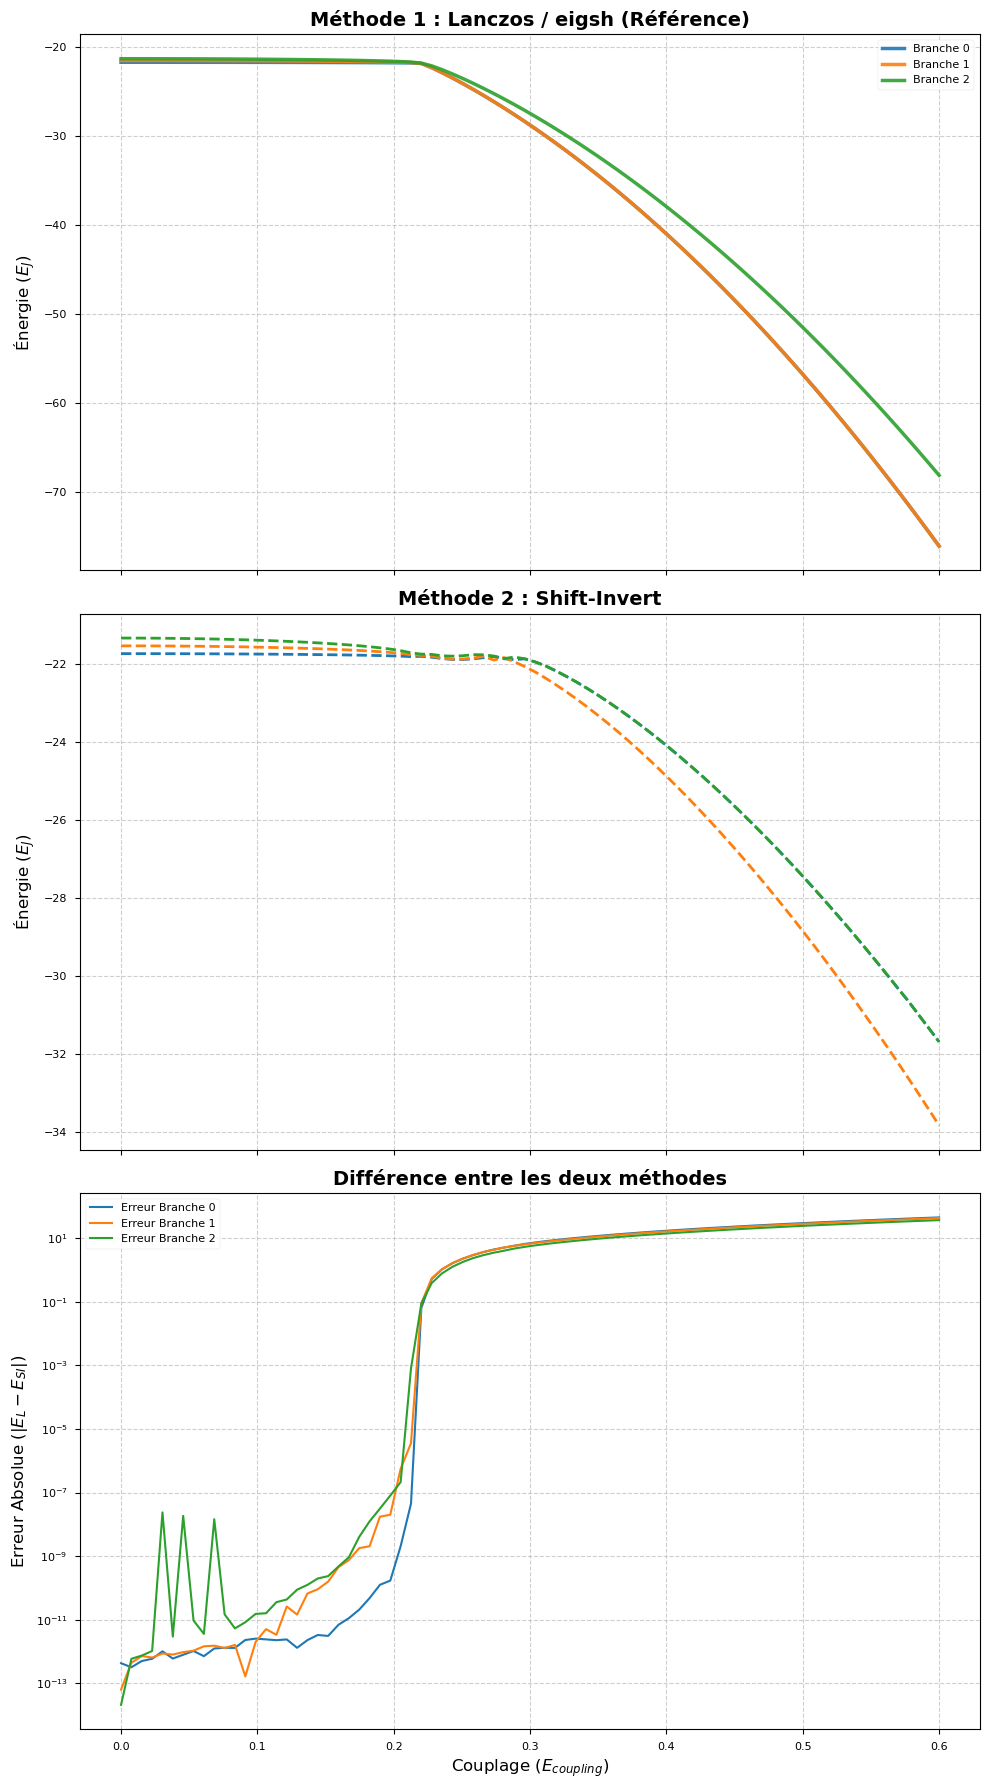

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Vérification des dimensions pour le plot
# Matplotlib aime avoir (n_steps, n_branches) pour tracer les colonnes.
# Si tes données sont (3, 80), on transpose pour avoir (80, 3).
if energies_l_c.shape[0] != len(coupling_list):
    energies_l_c = energies_l_c.T
if energies_si_opt_c.shape[0] != len(coupling_list):
    energies_si_opt_c = energies_si_opt_c.T

# 2. Calcul de la différence (Erreur absolue)
diff = np.abs(energies_l_c - energies_si_opt_c)

# 3. Création des 3 graphiques
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# --- Plot 1 : Lanczos (Référence) ---
axs[0].plot(coupling_list, energies_l_c, linewidth=2.5, alpha=0.9)
axs[0].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[0].set_title("Méthode 1 : Lanczos / eigsh (Référence)", fontsize=14, fontweight="bold")
axs[0].grid(True, which="both", linestyle="--", alpha=0.6)
axs[0].legend([f"Branche {i}" for i in range(energies_l_c.shape[1])], loc="upper right")

# --- Plot 2 : Shift-Invert (Ton Algo) ---
# J'utilise des tirets (--) pour bien distinguer visuellement du trait plein
axs[1].plot(coupling_list, energies_si_opt_c, linewidth=2, linestyle="--")
axs[1].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[1].set_title("Méthode 2 : Shift-Invert", fontsize=14, fontweight="bold")
axs[1].grid(True, which="both", linestyle="--", alpha=0.6)

# --- Plot 3 : Différence (Échelle Logarithmique) ---
# C'est ici qu'on juge la qualité de la convergence
for i in range(diff.shape[1]):
    axs[2].semilogy(coupling_list, diff[:, i], label=f"Erreur Branche {i}", linewidth=1.5)

axs[2].set_ylabel("Erreur Absolue ($|E_L - E_{SI}|$)", fontsize=12)
axs[2].set_xlabel("Couplage ($E_{coupling}$)", fontsize=12)
axs[2].set_title("Différence entre les deux méthodes", fontsize=14, fontweight="bold")
axs[2].grid(True, which="both", linestyle="--", alpha=0.6)
axs[2].legend()

# Mise en page
plt.tight_layout()
plt.show()